# Large-Scale SAE Analysis with UniProt Dataset

This notebook demonstrates how to analyze sparse autoencoders (SAEs) using a larger UniProt dataset,
following the InterPLM recommendations. We'll download Swiss-Prot data, create annotations, and mine SAE features.

In [1]:
from pathlib import Path
import pandas as pd, torch, os, gc
from interplm.sae.inference import load_sae_from_hf
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, EsmModel, AutoModel
from interplm.sae.inference import load_sae_from_hf
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
DEVICE="cuda"
DTYPE  = torch.float16


DATA_DIR = Path("esm_sae_results"); DATA_DIR.mkdir(exist_ok=True)
SEQUENCES_DIR = Path("/home/ec2-user/SageMaker/InterPLM/data/uniprot/subset_40k.csv")
# ANNOTATIONS_DIR = Path("uniprotkb_swissprot_annotations.tsv.gz")
ANNOTATIONS_DIR = Path("/home/ec2-user/SageMaker/InterPLM/uniprotkb_swissprot_annotations.tsv.gz")


/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D", do_lower_case=False)
model     = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D",
                                        output_hidden_states=True).to(DEVICE).eval()

# Make sure the SAE you load matches the *plm_model* and *plm_layer* you want to use
plm_model = "esm2-650m"   # matches your checkpoint naming
plm_layer = 24            # <= MUST match esm_layer_sel
sae = load_sae_from_hf(plm_model=plm_model, plm_layer=plm_layer).to(DEVICE).eval()


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Sequence Statistics ===
count    40000.000000
mean       344.486825
std        184.688538
min         50.000000
25%        186.000000
50%        330.000000
75%        461.000000
max       1022.000000
Name: length, dtype: float64


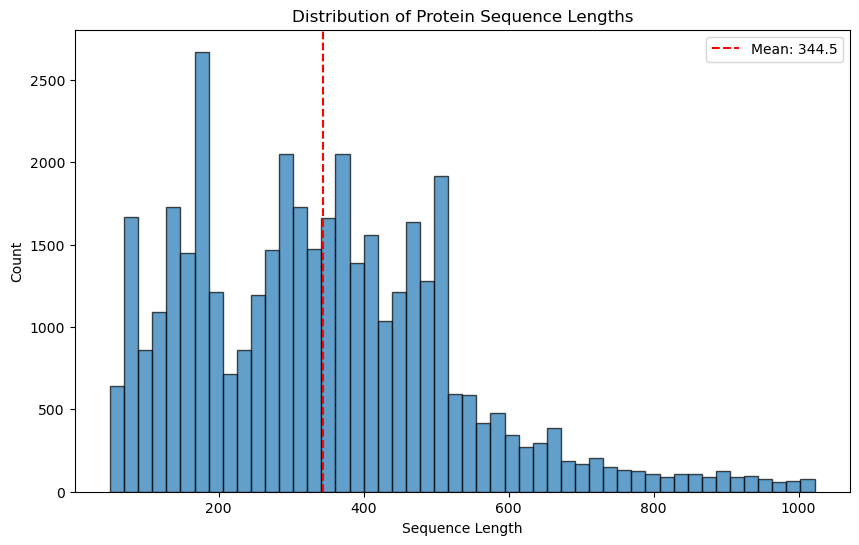

In [3]:
# Create larger subset for better analysis
sequences_df = pd.read_csv(SEQUENCES_DIR)

# Display basic statistics
print("\n=== Sequence Statistics ===")
print(sequences_df['length'].describe())

# Plot length distribution
plt.figure(figsize=(10, 6))
plt.hist(sequences_df['length'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Protein Sequence Lengths')
plt.axvline(sequences_df['length'].mean(), color='red', linestyle='--', 
           label=f'Mean: {sequences_df["length"].mean():.1f}')
plt.legend()
plt.show()

## 1. Setup and Imports

In [4]:
from interplm.sae.inference import load_sae_from_hf

from transformers import AutoTokenizer, AutoModel
import torch
from typing import List, Literal, Tuple
@torch.no_grad()
def extract_sae_features(hidden_states: torch.Tensor, sae):
    """
    Pass ESM hidden states through the Sparse Autoencoder (SAE).

    Args
    ----
    hidden_states : torch.Tensor
        Shape [B, L, d] or [L, d].
        - B = batch size (optional if unsqueezed)
        - L = sequence length
        - d = ESM embedding dimension (e.g., 1280 for esm2_t33_650M)

    Returns
    -------
    sae_features : torch.Tensor
        Shape [B, L, F]
        Sparse latent features per residue.
        F = number of SAE dictionary atoms / features.

    recon : torch.Tensor
        Shape [B, L, d]
        Reconstructed embeddings in token space.

    error : torch.Tensor
        Shape [B, L, d]
        Residual = hidden_states - recon
    """
    if hidden_states.dim() == 2:          # [L, d]
        hidden_states = hidden_states.unsqueeze(0)  # → [1, L, d]
    x = hidden_states.to(torch.float32)      # <- ensure fp32 for SAE

    # SAE should have encode() and decode() that operate on last dimension
    sae_features = sae.encode(x)     # [B, L, F]
    recon        = sae.decode(sae_features)      # [B, L, d]
    error        = hidden_states - recon         # [B, L, d]

    return sae_features, recon, error

def pool_sequence_features(
    features: torch.Tensor,   # [B, L, F] or [L, F]
    method: str = "maX",
    mask: torch.Tensor = None # optional [B, L] attention mask
) -> torch.Tensor:
    """
    Pool per-residue features to per-sequence vectors.

    Args
    ----
    features : torch.Tensor
        Shape [B, L, F] (or [L, F] → will unsqueeze to batch 1).
        - B = batch size
        - L = sequence length
        - F = number of SAE features
    method : str
        "maX" → concatenate mean + max → [B, 2F]
        "mean"     → masked mean → [B, F]
        "max"      → masked max  → [B, F]
    mask : torch.Tensor, optional
        Shape [B, L] bool (True = valid residue, False = pad).
        If None, assumes all tokens are valid.

    Returns
    -------
    pooled : torch.Tensor
        Shape depends on method:
          - maX: [B, 2F]
          - mean or max: [B, F]
    """
    if features.dim() == 2:  # [L, F]
        features = features.unsqueeze(0)  # [1, L, F]

    B, L, F = features.shape
    if mask is None:
        mask = torch.ones(B, L, dtype=torch.bool, device=features.device)

    # apply mask
    mask_f = mask.float().unsqueeze(-1)  # [B, L, 1]
    feats_masked = features * mask_f

    if method == "mean":
        pooled = feats_masked.sum(1) / mask_f.sum(1).clamp_min(1e-8)
        return pooled  # [B, F]

    elif method == "max":
        very_neg = torch.finfo(features.dtype).min
        feats_masked = feats_masked.masked_fill(~mask.unsqueeze(-1), very_neg)
        return feats_masked.max(1).values  # [B, F]

    elif method == "maX":
        mean_pool = feats_masked.sum(1) / mask_f.sum(1).clamp_min(1e-8)  # [B, F]
        very_neg = torch.finfo(features.dtype).min
        feats_masked = feats_masked.masked_fill(~mask.unsqueeze(-1), very_neg)
        max_pool = feats_masked.max(1).values  # [B, F]
        return torch.cat([mean_pool, max_pool], dim=-1)  # [B, 2F]

    else:
        raise ValueError(f"Unknown pooling method: {method}")
        
@torch.no_grad()
def extract_esm_features_batch(
    sequences: List[str],
    layer_sel: int | Literal["last"] = "last",   # <— changed name/type
    device: torch.device = DEVICE,
    dtype = torch.float16,
    model = None,
    tokenizer = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    batch = tokenizer(sequences, return_tensors="pt", add_special_tokens=False, padding=True)
    batch = {k: v.to(device) for k, v in batch.items()}
    attn_mask = batch["attention_mask"].to(torch.bool)

    with torch.autocast(device_type="cuda", dtype=dtype):
        out = model(**batch, output_hidden_states=True, return_dict=True)
        hs = out.hidden_states  # tuple: [emb, layer1, ..., layerN] each [B,L,d]
        if layer_sel == "last":
            token_reps = hs[-1]
        elif isinstance(layer_sel, int):
            # ESM layers are 1-indexed in HF hidden_states after the embedding; adjust if you stored 0/1-based
            token_reps = hs[layer_sel]  # e.g., 24th encoder block reps
        else:
            raise ValueError(f"Invalid layer_sel: {layer_sel}")
    return token_reps, attn_mask


In [5]:
import os, gc
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm


def _to_cpu_and_free(*tensors):
    out = []
    for t in tensors:
        if t is None:
            out.append(None)
            continue
        out.append(t.detach().to("cpu", non_blocking=True))
        del t
    torch.cuda.empty_cache()
    gc.collect()
    return out if len(out) > 1 else out[0]

def process_sequences_bucketed(
    sequences_df: pd.DataFrame,
    batch_size: int = 16,
    save_every: int = 1000,
    cache_name: str = "sae_features",
    desc: str = "processing",
    esm_layer_sel: int | Literal["last"] = "last",   # <— renamed
    model=None,
    sae=None,
    tokenizer=None,
    device: torch.device = DEVICE,
    amp_dtype = DTYPE,
) -> pd.DataFrame:
    model.eval()
    DATA_DIR.mkdir(exist_ok=True, parents=True)
    cache_dir = DATA_DIR / f"{cache_name}_cache"
    cache_dir.mkdir(exist_ok=True)

    df = sequences_df.copy()
    df["L"] = df["sequence"].str.len()
    df = df.sort_values("L").reset_index(drop=True)

    results, processed, next_save_threshold = [], 0, save_every
    pbar = tqdm(total=len(df), desc=desc, dynamic_ncols=True)

    cur_bs, i = batch_size, 0
    while i < len(df):
        window = df.iloc[i : min(i + cur_bs, len(df))]
        seqs = window["sequence"].tolist()
        ids  = window["uniprot_id"].tolist()

        try:
            with torch.no_grad(), torch.autocast(device_type="cuda", dtype=amp_dtype):
                token_reps, attn_mask = extract_esm_features_batch(
                    seqs, layer_sel=esm_layer_sel, device=device, dtype=amp_dtype,
                    model=model, tokenizer=tokenizer
                )
                sae_feats, recon, err = extract_sae_features(token_reps, sae)

                pooled = pool_sequence_features(sae_feats, mask=attn_mask, method="mean")  # [B,F]
                pooled, sae_feats, err = _to_cpu_and_free(pooled, sae_feats, err)

            for j, uid in enumerate(ids):
                results.append({
                    "uniprot_id": uid,
                    "length": int(len(seqs[j])),
                    "features": pooled[j].numpy(),                # [F]
                    "max_activation": sae_feats[j].amax().item(),
                    "n_active_features": (sae_feats[j] > 0.1).sum().item(),
                    "reconstruction_mse": err[j].pow(2).mean().item(),
                })

            processed += len(window); pbar.update(len(window)); i += len(window)
            if processed >= next_save_threshold or processed == len(df):
                cache_file = cache_dir / f"{cache_name}_{processed}.pkl"
                pd.DataFrame(results).to_pickle(cache_file)
                print(f"[checkpoint] saved {processed} → {cache_file}")
                next_save_threshold += save_every

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                torch.cuda.empty_cache(); gc.collect()
                if cur_bs > 1:
                    cur_bs = max(1, cur_bs // 2)
                    print(f"[OOM] reducing batch_size → {cur_bs} and retrying")
                    continue
                else:
                    print(f"[OOM] Skipping {ids[0]} (len={len(seqs[0])})")
                    i += 1; pbar.update(1); continue
            else:
                print(f"[ERROR] {ids[0]}: {e}")
                i += 1; pbar.update(1); continue

    pbar.close()
    out_df = pd.DataFrame(results)
    out_path = DATA_DIR / f"{cache_name}.pkl"
    out_df.to_pickle(out_path)
    print(f"[done] {len(out_df)} sequences → {out_path}")
    return out_df


## Parallel processing

In [14]:
# import ray, os, pandas as pd, torch
# from pathlib import Path
# from interplm.sae.inference import load_sae_from_hf
# from transformers import AutoTokenizer, AutoModel

# ray.shutdown()
# ray.init(ignore_reinit_error=True, num_gpus=8)

# DATA_DIR = Path("esm_sae_results"); DATA_DIR.mkdir(exist_ok=True)
# sequences_df.to_pickle(DATA_DIR / "sequences_df.pkl")

# @ray.remote(num_gpus=1)
# def ray_worker(rank: int, world_size: int, input_path: str, out_name: str,
#                batch_size: int = 16, save_every: int = 1000,
#                esm_layer_sel: int | Literal["last"] = 24):
#     os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True,max_split_size_mb:128")

#     # Each Ray task sees 1 GPU as cuda:0
#     DEVICE = torch.device("cuda:0")
#     DTYPE  = torch.float16

#     # Load ESM and SAE inside the worker
#     tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D", do_lower_case=False)
#     model     = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D",
#                                           output_hidden_states=True).to(DEVICE).eval()

#     # Make sure the SAE you load matches the *plm_model* and *plm_layer* you want to use
#     plm_model = "esm2-650m"   # matches your checkpoint naming
#     plm_layer = 24            # <= MUST match esm_layer_sel
#     sae = load_sae_from_hf(plm_model=plm_model, plm_layer=plm_layer).to(DEVICE).eval()

#     df = pd.read_pickle(input_path)
#     shard = df.iloc[rank::world_size].reset_index(drop=True)

#     cache_name = f"{out_name}_rank{rank}"
#     out_df = process_sequences_bucketed(
#         sequences_df=shard,
#         batch_size=batch_size,
#         save_every=save_every,
#         cache_name=cache_name,
#         desc=f"rank{rank}",
#         esm_layer_sel=esm_layer_sel,
#         model=model,
#         sae=sae,
#         tokenizer=tokenizer,
#         device=DEVICE,
#         amp_dtype=DTYPE,
#     )

#     out_path = DATA_DIR / f"{cache_name}.final.pkl"
#     out_df.to_pickle(out_path)
#     return str(out_path)


2025-09-12 19:39:21,989	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-09-12 19:39:23,572	INFO worker.py:1951 -- Started a local Ray instance.


In [6]:
# WORLD_SIZE = 8
# input_path = str(DATA_DIR / "sequences_df.pkl")
# futs = [ray_worker.remote(r, WORLD_SIZE, input_path, "sae_features") for r in range(WORLD_SIZE)]
# paths = ray.get(futs)
# paths

In [7]:
features_all = pd.read_pickle("features_all.pkl")

In [8]:
features_all.head(10)

,uniprot_id,length,features,max_activation,n_active_features,reconstruction_mse
0,Q9GL23,50,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002...",1.265625,1876,45.198380
1,Q6GZU6,50,"[0.00023197175, 0.0, 0.0, 0.0, 0.0013056946, 0...",0.843262,2168,13.467114
2,P9WJG6,50,"[0.0, 0.00057144166, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.935059,1740,12.720748
3,P18924,51,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",0.956543,1799,11.394856
4,Q08076,52,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",1.139648,1772,24.694654
5,P15450,53,"[0.0, 0.00019778845, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.090820,1698,13.188174
6,P40643,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031...",0.881348,1450,21.303719
7,P12697,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001...",1.243164,1535,21.009787
8,O78683,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",1.144531,1657,20.722115
9,Q9MJC0,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001...",1.224609,1680,25.309597


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Quick peek at the annotation file ---
annotations_path = Path(ANNOTATIONS_DIR)  # update with your path
df = pd.read_csv(annotations_path, sep="\t", compression="gzip")
print("Columns in UniProt annotations:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head(3).T)  # transpose to make it easier to read

Columns in UniProt annotations:
['Entry', 'Reviewed', 'Protein names', 'Length', 'Sequence', 'EC number', 'Active site', 'Binding site', 'Cofactor', 'Disulfide bond', 'Glycosylation', 'Lipidation', 'Modified residue', 'Signal peptide', 'Transit peptide', 'Helix', 'Turn', 'Beta strand', 'Coiled coil', 'Domain [CC]', 'Compositional bias', 'Domain [FT]', 'Motif', 'Region', 'Zinc finger']

First few rows:
                                                                    0  \
Entry                                                      A0A009IHW8   
Reviewed                                                     reviewed   
Protein names       2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...   
Length                                                            269   
Sequence            MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...   
EC number                                            3.2.2.-; 3.2.2.6   
Active site         ACT_SITE 208; /evidence="ECO:0000255|PROSITE-P...   
Binding sit

In [24]:
# --- 2. Pick a few IDs you processed ---
# features_all = pd.read_csv("features.csv")
print("\nExample UniProt IDs in your features_all:")
print(features_all['uniprot_id'].head().tolist())

# --- 3. Check if those IDs exist in the annotations ---
ids_to_check = features_all['uniprot_id'].head(5).tolist()
sub = pd.read_csv(annotations_path, sep="\t", compression="gzip")
print(sub.shape)
sub = sub[sub['Entry'].isin(ids_to_check)]
print(sub.shape)
print(f"\nFound {len(sub)} matches in annotations:")
print(sub[['Entry','Protein names','Length']].head())


Example UniProt IDs in your features_all:
['Q9GL23', 'Q6GZU6', 'P9WJG6', 'P18924', 'Q08076']
(573661, 25)
(5, 25)

Found 5 matches in annotations:
         Entry                                      Protein names  Length
222838  Q08076  ATP synthase protein 8 (A6L) (F-ATPase subunit 8)      52
425062  P18924                       Uncharacterized protein 52.2      51
441576  P9WJG6              Uncharacterized membrane protein ArfB      50
531041  Q9GL23    Apoptotic protease-activating factor 1 (APAF-1)      50
567402  Q6GZU6                       Uncharacterized protein 030R      50


In [10]:
# import requests
# from pathlib import Path
# from tqdm import tqdm

# fields = (
#     "accession,reviewed,protein_name,length,sequence,"
#     "ec,ft_act_site,ft_binding,cc_cofactor,ft_disulfid,"
#     "ft_carbohyd,ft_lipid,ft_mod_res,ft_signal,ft_transit,"
#     "ft_helix,ft_turn,ft_strand,ft_coiled,cc_domain,"
#     "ft_compbias,ft_domain,ft_motif,ft_region,ft_zn_fing"
# )
# url = (
#     "https://rest.uniprot.org/uniprotkb/stream"
#     f"?format=tsv&compressed=true&fields={fields}"
#     "&query=(reviewed:true)"
# )

# out = Path("uniprotkb_swissprot_annotations.tsv.gz")
# print("Downloading Swiss-Prot annotations…")

# # stream in chunks
# with requests.get(url, stream=True) as r:
#     r.raise_for_status()
#     total_size = int(r.headers.get("Content-Length", 0))
#     chunk_size = 1024 * 1024  # 1 MB
#     with open(out, "wb") as f, tqdm(
#         total=total_size, unit="B", unit_scale=True, desc="Downloading"
#     ) as pbar:
#         for chunk in r.iter_content(chunk_size=chunk_size):
#             f.write(chunk)
#             pbar.update(len(chunk))

# print("Saved:", out)


## 6. Create Rich Protein Annotations

Extract and process UniProt annotations to create binary concept labels.

Loading annotations from /home/ec2-user/SageMaker/InterPLM/uniprotkb_swissprot_annotations.tsv.gz...
Index(['Entry', 'Reviewed', 'Protein names', 'Length', 'Sequence', 'EC number',
       'Active site', 'Binding site', 'Cofactor', 'Disulfide bond',
       'Glycosylation', 'Lipidation', 'Modified residue', 'Signal peptide',
       'Transit peptide', 'Helix', 'Turn', 'Beta strand', 'Coiled coil',
       'Domain [CC]', 'Compositional bias', 'Domain [FT]', 'Motif', 'Region',
       'Zinc finger'],
      dtype='object')
Loaded 573661 protein annotations
\nFiltering annotations to match processed sequences...
After filtering: 40000 annotations remain
Available columns: ['Entry', 'Reviewed', 'Protein names', 'Length', 'Sequence', 'EC number', 'Active site', 'Binding site', 'Cofactor', 'Disulfide bond', 'Glycosylation', 'Lipidation', 'Modified residue', 'Signal peptide', 'Transit peptide', 'Helix', 'Turn', 'Beta strand', 'Coiled coil', 'Domain [CC]', 'Compositional bias', 'Domain [FT]', 'Motif

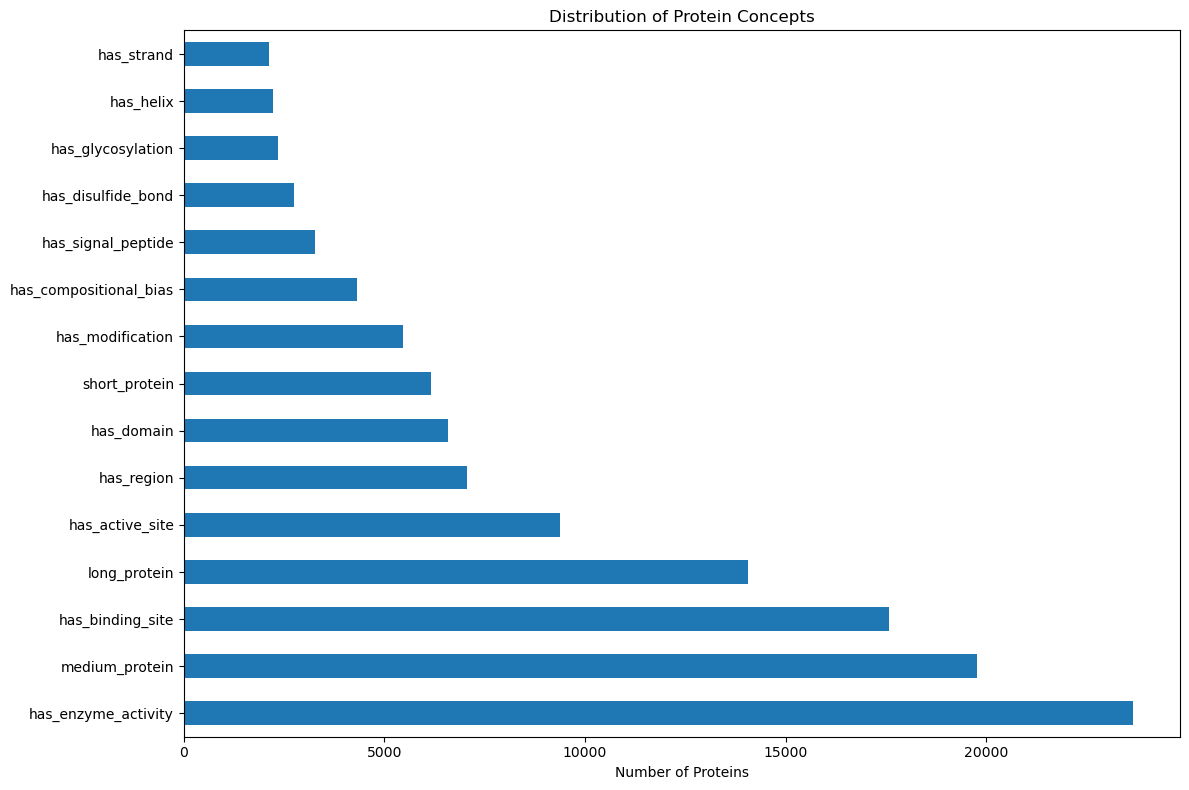

In [11]:
def parse_uniprot_annotations(annotations_path: Path):
    """
    Parse UniProt annotations and create binary concept labels.
    """
    print(f"Loading annotations from {annotations_path}...")
    
    # Read the TSV file
    annotations_df = pd.read_csv(annotations_path, sep='\t', compression='gzip')
    print(annotations_df.columns)
    print(f"Loaded {len(annotations_df)} protein annotations")

    # Filter annotations to match our sequence subset
    print(f"\\nFiltering annotations to match processed sequences...")
    processed_ids = set(sequences_df['uniprot_id'])
    annotations_df = annotations_df[annotations_df['Entry'].isin(processed_ids)]

    print(f"After filtering: {len(annotations_df)} annotations remain")
    print(f"Available columns: {list(annotations_df.columns)}")
    if len(annotations_df) == 0:
        print("ERROR: No matching annotations found!")
        print("This suggests the UniProt IDs don't match between FASTA and annotations.")
        print("Checking a few examples...")
        print(f"FASTA IDs (first 5): {list(sequences_df['uniprot_id'].head())}")
        # Try loading a few annotation entries to see format
        temp_df = pd.read_csv(annotations_path, sep='\\t', compression='gzip', nrows=5)
        print(f"Annotation IDs (first 5): {list(temp_df['Entry'])}")
        return None, None
    
    # Create binary concept labels
    concepts = {}
    
    # Structural features
    concepts['Entry'] = annotations_df['Entry']
    concepts['has_signal_peptide'] = ~annotations_df['Signal peptide'].isna()
    concepts['has_disulfide_bond'] = ~annotations_df['Disulfide bond'].isna()
    concepts['has_helix'] = ~annotations_df['Helix'].isna()
    concepts['has_strand'] = ~annotations_df['Beta strand'].isna()
    concepts['has_turn'] = ~annotations_df['Turn'].isna()
    concepts['has_coiled_coil'] = ~annotations_df['Coiled coil'].isna()
    
    # Post-translational modifications
    concepts['has_glycosylation'] = ~annotations_df['Glycosylation'].isna()
    concepts['has_lipidation'] = ~annotations_df['Lipidation'].isna()
    concepts['has_modification'] = ~annotations_df['Modified residue'].isna()
    
    # Functional features
    concepts['has_active_site'] = ~annotations_df['Active site'].isna()
    concepts['has_binding_site'] = ~annotations_df['Binding site'].isna()
    concepts['has_enzyme_activity'] = ~annotations_df['EC number'].isna()
    
    # Sequence features
    concepts['has_domain'] = ~annotations_df['Domain [FT]'].isna()
    concepts['has_motif'] = ~annotations_df['Motif'].isna()
    concepts['has_region'] = ~annotations_df['Region'].isna()
    concepts['has_zinc_finger'] = ~annotations_df['Zinc finger'].isna()
    concepts['has_compositional_bias'] = ~annotations_df['Compositional bias'].isna()
    
    # Length-based categories
    concepts['short_protein'] = annotations_df['Length'] < 150
    concepts['medium_protein'] = (annotations_df['Length'] >= 150) & (annotations_df['Length'] < 400)
    concepts['long_protein'] = annotations_df['Length'] >= 400
    print("before pd")
    # Convert to DataFrame
    concepts_df = pd.DataFrame(concepts)
    # Add sequence information
    concepts_df['sequence'] = annotations_df['Sequence'].values
    concepts_df['length'] = annotations_df['Length'].values
    concepts_df['protein_name'] = annotations_df['Protein names'].values
    
    return concepts_df, annotations_df

# Parse annotations
concepts_df, raw_annotations = parse_uniprot_annotations(ANNOTATIONS_DIR)

if concepts_df is not None:
    print(f"\\nCreated {len(concepts_df)} concept annotations")
    print(f"Available concepts: {[col for col in concepts_df.columns if col not in ['sequence', 'length', 'protein_name']]}")
    
    # Show concept statistics
    concept_cols = [col for col in concepts_df.columns if col not in ['Entry', 'sequence', 'length', 'protein_name']]
    concept_stats = concepts_df[concept_cols].sum().sort_values(ascending=False)
    
    print("\\n=== Concept Statistics ===")
    for concept, count in concept_stats.head(15).items():
        pct = 100 * count / len(concepts_df)
        print(f"{concept:25s}: {count:5d} ({pct:5.1f}%)")
    
    # Visualize concept distribution
    plt.figure(figsize=(12, 8))
    concept_stats.head(15).plot(kind='barh')
    plt.xlabel('Number of Proteins')
    plt.title('Distribution of Protein Concepts')
    plt.tight_layout()
    plt.show()
else:
    print("Failed to parse annotations - please check the data sources.")

In [12]:
concepts_df
concepts_df = concepts_df.set_index('Entry')

## 7. Match Features with Annotations

Align the extracted SAE features with the protein annotations for analysis.

In [13]:
# Match features with concepts by UniProt ID
feature_ids = set(features_all['uniprot_id'])
concept_ids = set(concepts_df.index)
common_ids = feature_ids.intersection(concept_ids)

print(f"Features extracted for: {len(feature_ids)} proteins")
print(f"Concepts available for: {len(concept_ids)} proteins")
print(f"Common proteins: {len(common_ids)} proteins")

Features extracted for: 40000 proteins
Concepts available for: 40000 proteins
Common proteins: 40000 proteins


In [14]:

if len(common_ids) < 500:
    print("\nWarning: Overlap between features and concepts could be higher.")
    print(f"Current overlap: {len(common_ids)} proteins")
    if len(common_ids) < 100:
        print("Very low overlap - this might limit analysis quality.")
else:
    print(f"\nGood overlap: {len(common_ids)} proteins for analysis")

# Create matched dataset (convert set to list for pandas indexing)
matched_features = features_all[features_all['uniprot_id'].isin(common_ids)]

matched_features = features_all[features_all['uniprot_id'].isin(common_ids)].set_index('uniprot_id')


matched_concepts = concepts_df.loc[list(common_ids)]

# Align the data
aligned_data = matched_features.join(matched_concepts, how='inner',  lsuffix='_feat', rsuffix='_ann')

print(f"\nAligned dataset: {len(aligned_data)} proteins")



Good overlap: 40000 proteins for analysis

Aligned dataset: 40000 proteins


In [15]:
aligned_data.iloc[0]['features'].shape
# print(f"Feature dimension: {aligned_data['features'].iloc[0].shape[0]}")

(10240,)

In [16]:
first_features = aligned_data.iloc[0]['features']
first_features


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [17]:

# Create feature matrix
X = np.vstack(aligned_data['features'].values)
print(X.shape[1])


10240


In [18]:
print(f"Feature matrix shape: {X.shape}")

# Get concept labels
concept_cols = [col for col in aligned_data.columns 
                if col not in ['features', 'length_feat', 'length_ann', 'max_activation', 'n_active_features', 
                               'reconstruction_mse', 'sequence', 'protein_name']]
Y = aligned_data[concept_cols].astype(int)

print(f"\nConcept matrix shape: {Y.shape}")
print(f"Available concepts for analysis: {len(concept_cols)}")

# Show concept statistics for the aligned dataset
print("\n=== Concept Statistics (Aligned Data) ===")
concept_stats_aligned = Y.sum().sort_values(ascending=False)
for concept, count in concept_stats_aligned.head(15).items():
    pct = 100 * count / len(Y)
    print(f"{concept:25s}: {count:5d} ({pct:5.1f}%)")

Feature matrix shape: (40000, 10240)

Concept matrix shape: (40000, 20)
Available concepts for analysis: 20

=== Concept Statistics (Aligned Data) ===
has_enzyme_activity      : 23644 ( 59.1%)
medium_protein           : 19758 ( 49.4%)
has_binding_site         : 17583 ( 44.0%)
long_protein             : 14072 ( 35.2%)
has_active_site          :  9371 ( 23.4%)
has_region               :  7058 ( 17.6%)
has_domain               :  6581 ( 16.5%)
short_protein            :  6170 ( 15.4%)
has_modification         :  5471 ( 13.7%)
has_compositional_bias   :  4323 ( 10.8%)
has_signal_peptide       :  3271 (  8.2%)
has_disulfide_bond       :  2755 (  6.9%)
has_glycosylation        :  2335 (  5.8%)
has_helix                :  2231 (  5.6%)
has_strand               :  2133 (  5.3%)


## 8. SAE Feature Mining and Analysis

Analyze which SAE features are associated with different protein concepts.

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

## Grab association

In [34]:
def compute_feature_concept_associations(X_features: np.ndarray, Y_concepts:pd.DataFrame, min_concept_instances: int=5):
    """
    Compute associations between SAE features and protein concepts using AUC.

    Args:
        X_features: numpy array of shape (n_samples, n_features)
        Y_concepts: dataframe of shape (n_samples, n_concepts) with binary values
        min_concept_instances: skip concepts with fewer positives/negatives than this
    """

    results = {}
    n_features = X_features.shape[1]

    print(f"Computing associations for {n_features} features and {len(Y_concepts.columns)} concepts ...")

    #Loop through each concept column

    for concept in Y_concepts.columns:
        y = Y_concepts[concept].values #binary labels (0/1)

        #Skip if too few positive/negative samples
        if y.sum() < min_concept_instances or (len(y) - y.sum()) < min_concept_instances:
            print(f"  Skipping {concept}: only {y.sum()}/{len(y)} positives")
            continue
        print(f"  Processing {concept}: {y.sum()}/{len(y)} positives")

        aucs = []
        for feature_idx in range(n_features):
            #also the features are mean pooled to get it for each sequence: what is the point of per residue features? i feel like the labels don't necessarily apply...
            feature_values = X_features[:, feature_idx]

            #Skip non-informative features
            if len(np.unique(feature_values))< 2:
                aucs.append(0.5) # baseline AUC
                continue

            try:
                auc = roc_auc_score(y, feature_values)
                aucs.append(auc)
            except ValueError:
                print("value error")
                aucs.append(0.5)
        
        #convert to numpy arra for ranking
        aucs = np.array(aucs)

        #ranking features by distance from random (0.5)
        
        #np.argsort of how far each auc is from the random baseline. 

        #[::-1] means start: nothing = whole array, stop: nothing default = end, step: -1 (go backwards)
        #Since np.argsort is smallest to largest. Then grabs the first 20.
        top_indices = np.argsort(np.abs(aucs - 0.5))[::-1][:20]

        results[concept] = {
        "aucs": aucs,
        "top_features": [(int(idx), aucs[idx]) for idx in top_indices],
        "n_positive": int(y.sum()),
        "n_total": len(y),
        }

    return results



In [35]:
print(X.shape) # should be (N_proteins, feature_dim) = (40k, 10240)
print(Y.shape) # Should be (n_proteins, n_concepts) = (40k, 20)

(40000, 10240)
(40000, 20)


In [36]:
if concepts_df is not None and len(aligned_data) > 0:
    associations = compute_feature_concept_associations(X, Y, min_concept_instances=10)
    print("\n=== Feature-Concept Associations ===")
    print(f"Analyzed {len(associations)} concepts")

    for concept, data in associations.items():
        top_features = data["top_features"][:5]
        print(f"\n{concept} ({data['n_positive']}/{data['n_total']} examples):")
        for feature_idx, auc in top_features:
            print(f"  Feature {feature_idx:4d}: AUC = {auc:.3f}")
else:
    print("Cannot compute associations - missing concept data or aligned dataset.")


Computing associations for 10240 features and 20 concepts ...
  Processing has_signal_peptide: 3271/40000 positives
  Processing has_disulfide_bond: 2755/40000 positives
  Processing has_helix: 2231/40000 positives
  Processing has_strand: 2133/40000 positives
  Processing has_turn: 1899/40000 positives
  Processing has_coiled_coil: 634/40000 positives
  Processing has_glycosylation: 2335/40000 positives
  Processing has_lipidation: 537/40000 positives
  Processing has_modification: 5471/40000 positives
  Processing has_active_site: 9371/40000 positives
  Processing has_binding_site: 17583/40000 positives
  Processing has_enzyme_activity: 23644/40000 positives
  Processing has_domain: 6581/40000 positives
  Processing has_motif: 1476/40000 positives
  Processing has_region: 7058/40000 positives
  Processing has_zinc_finger: 831/40000 positives
  Processing has_compositional_bias: 4323/40000 positives
  Processing short_protein: 6170/40000 positives
  Processing medium_protein: 19758/40

In [20]:
from pathlib import Path
import pickle, gzip
from datetime import datetime

def save_associations(associations: dict, path: str | Path, meta: dict | None = None):
    """
    Pickle+gzip the associations dict. Include optional meta for sanity checks.
    """
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    payload = {
        "associations": associations,
        "meta": meta or {},
        "saved_at": datetime.now().isoformat(),
    }
    with gzip.open(path, "wb") as f:
        pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_associations(path: str | Path):
    path = Path(path)
    if not path.exists():
        return None
    with gzip.open(path, "rb") as f:
        return pickle.load(f)  # dict with keys: associations, meta, saved_at


In [22]:
cache_path = Path("annotations/associations.pkl.gz")

# optional metadata to help you verify the cache matches current data
meta = {
    "X_shape": tuple(X.shape),
    "Y_shape": tuple(Y.shape),
    "Y_columns": list(Y.columns),
    "min_concept_instances": 5,
}

# save
# save_associations(associations, cache_path, meta)

# later: load (no recompute)
payload = load_associations(cache_path)
if payload is not None:
    associations = payload["associations"]
    print("Loaded from cache with meta:", payload.get("meta"))


Loaded from cache with meta: {'X_shape': (40000, 10240), 'Y_shape': (40000, 20), 'Y_columns': ['has_signal_peptide', 'has_disulfide_bond', 'has_helix', 'has_strand', 'has_turn', 'has_coiled_coil', 'has_glycosylation', 'has_lipidation', 'has_modification', 'has_active_site', 'has_binding_site', 'has_enzyme_activity', 'has_domain', 'has_motif', 'has_region', 'has_zinc_finger', 'has_compositional_bias', 'short_protein', 'medium_protein', 'long_protein'], 'min_concept_instances': 5}


In [39]:
asc = associations

## Visualize feature patterns

In [40]:
import seaborn as sns

def plot_top_features_heatmap(associations: dict, X_features: np.ndarray, Y_concepts: pd.DataFrame, 
    top_k_per_concept: int = 10, max_features: int | None = None):
    """
    Build an AUC Matrix (concepts x features for the union of 'top_k_per_concept' features across concepts, then plot a heatmap.)

    associations: output of AUC analysis:
    {concept: {'aucs': (F,), 'top_features': [(feat_idx, auc), ...], ...} ... }
    X_Features: (N, F) feature matrix (only used for shape sanity)
    Y_concpets: (N, C) concept labels (used to preserve concept order)
    top_k_per_concept: how many top features to collect per concept
    max_features: optional cap on total feautres in the heatmap to avoid huge figures
    """

    assert isinstance(associations, dict) and len(associations) > 0, "No associations to plot."

    ##Collect top feature indicies across concepts 
    all_top = set()
    for concept, data in associations.items():
        #Data['top_features'] is list[(feat_idx, auc)], already ranked
        take = [f_idx for (f_idx, _auc) in data['top_features'][:top_k_per_concept]]
        all_top.update(take)
    all_top = sorted(all_top)

    if max_features is not None and len(all_top) > max_features:
        all_top = all_top[:max_features] # crude cap
    
    F_sel = len(all_top)

    ##Concept order
    #Keep display order consistent with Y_concepts columns where possible
    concept_names = [c for c in Y_concepts.columns if c in associations]
    
    for c in associations.keys():
        if c not in concept_names:
            concept_names.append(c)

    C = len(concept_names)

    #build AUC matrix
    auc_matrix = np.zeros((C, F_sel), dtype=float)

    for i, concept in enumerate(concept_names):
        aucs_vec = associations[concept]['aucs'] #shape: (F,)
        #fill selected columns
        for j, f_idx in enumerate (all_top):
            auc_matrix[i, j] = aucs_vec[f_idx]

    print("AUC matrix shape (concepts x selected_features): ", auc_matrix.shape)

    ##Plot
    plt.figure(figsize=(min(20, 1.2 * F_sel), min(0.6 * C + 2, 18)))
    
    xticklabels = [f"F{f}" for f in all_top]
    yticklabels = concept_names

    ax = sns.heatmap(auc_matrix, xticklabels=xticklabels, yticklabels=yticklabels, cmap='RdBu_r', center=0.5, cbar_kws = {'label':'AUC'})
    plt.title("Feature-Concept Association Heatmap (AUC)", pad=10)
    plt.xlabel('SAE Features')
    plt.ylabel("Protein concepts")
    plt.tight_layout()
    plt.show()

    return auc_matrix, concept_names, all_top







AUC matrix shape (concepts x selected_features):  (20, 75)


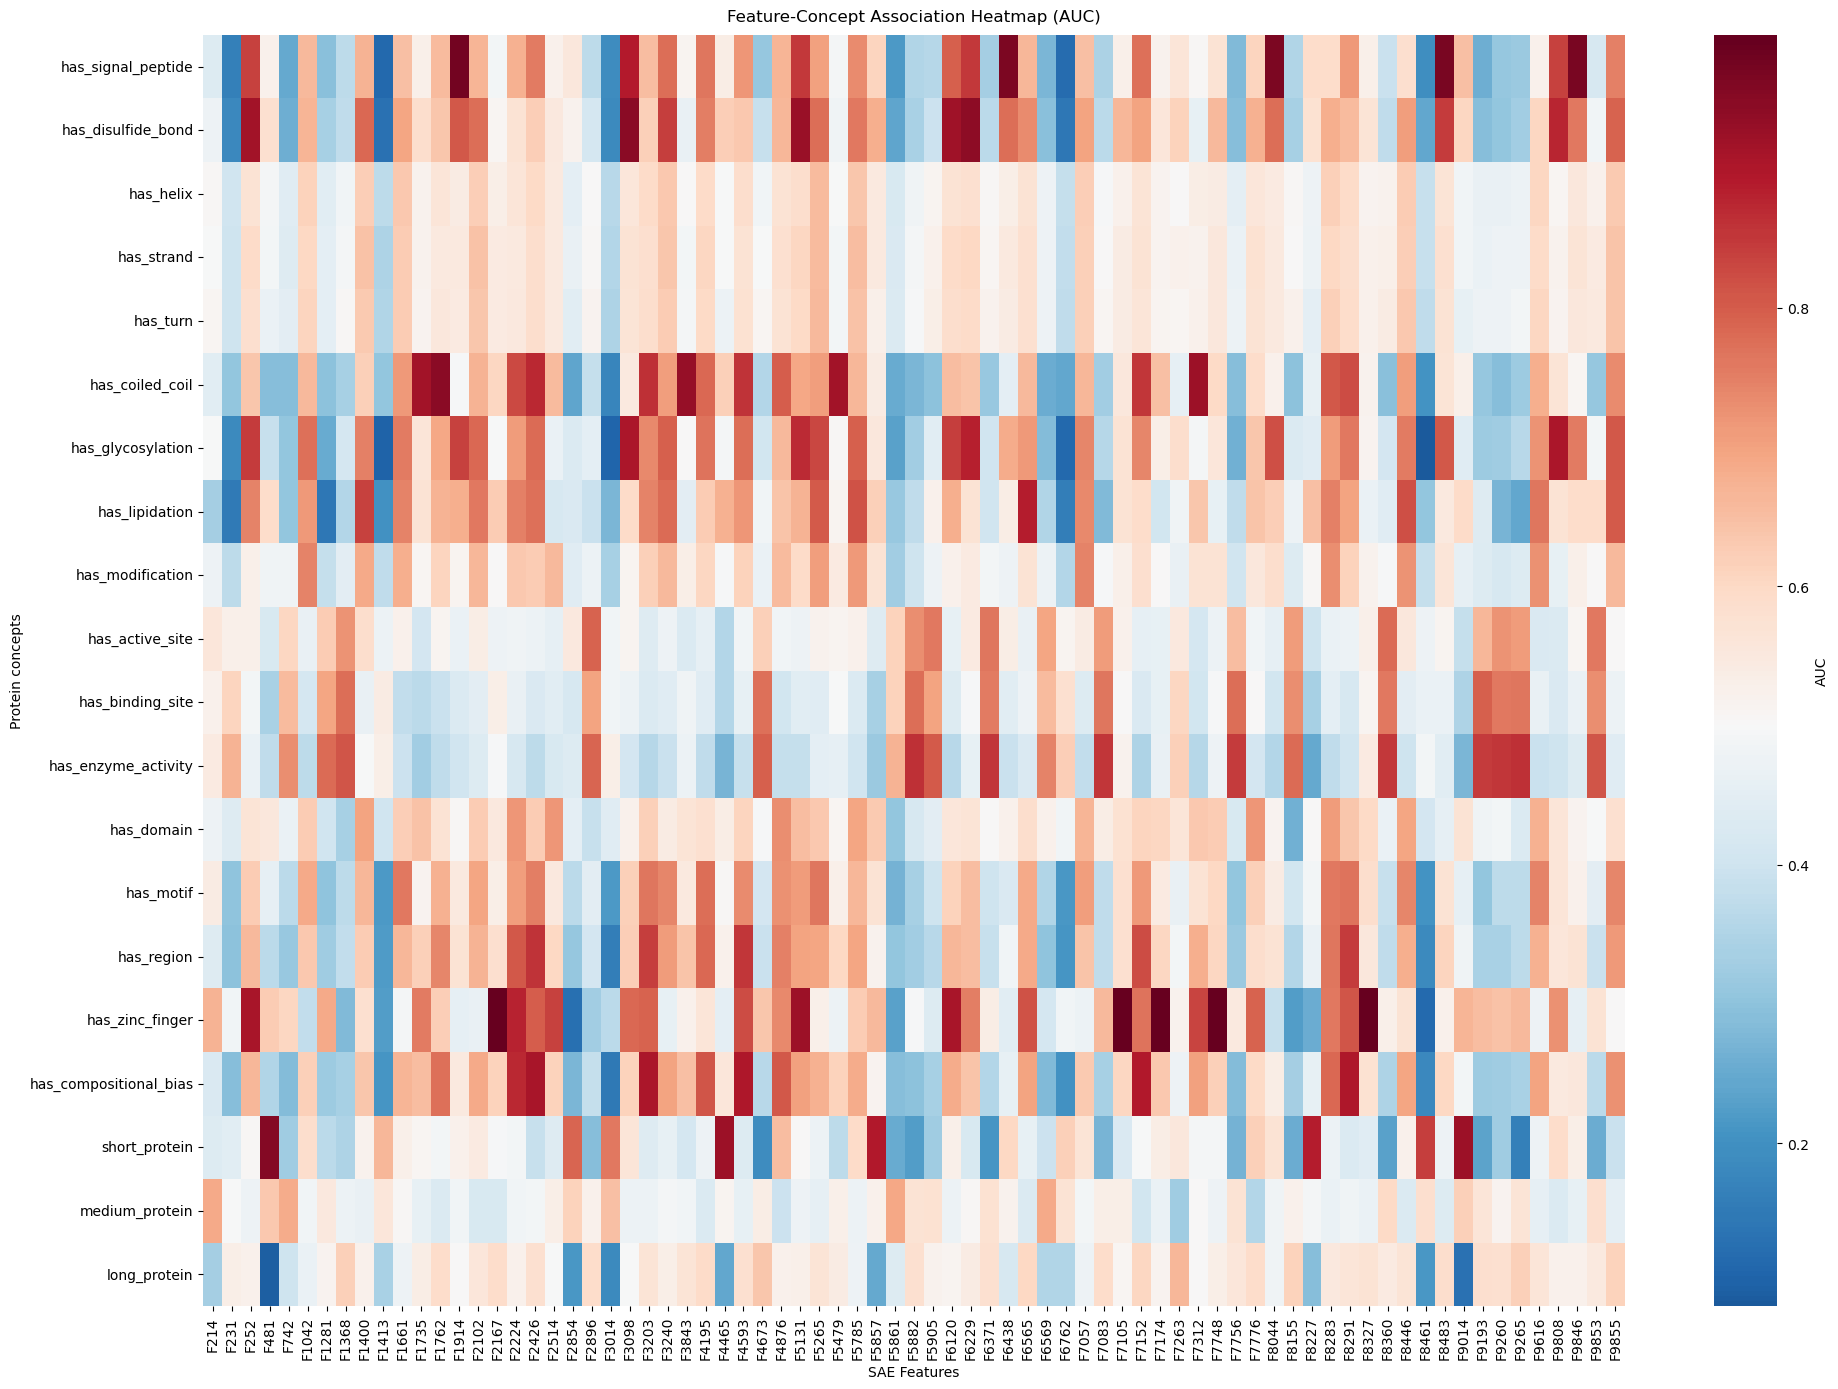

In [41]:
auc_matrix, concept_names, all_top = plot_top_features_heatmap(associations, X, Y, top_k_per_concept=5)

In [42]:
def plot_feature_distributions(feature_idx: int, concept: str, X_features: np.ndarray, Y_concepts: pd.DataFrame, bins: int = 30):
    """
    Plot the score distribution of a single feature for positives vs negatives of a concept
    feature_idx: index of the column in X_features (0..F-1)
    concept: column name in Y_concepts
    X_features: (N, F)
    Y_concepts: (N,C)
    """
    # Fetch arrays
    y = Y_concepts[concept].to_numpy()
    x = X_features[:, feature_idx]

    assert x.ndim == 1 and y.ndim == 1 and len(x) == len(y), "Shape mismatch."
    n_pos = int(y.sum())
    n_neg = len(y) - n_pos
    auc = None
    if n_pos > 0 and n_neg > 0:
        try:
            auc = roc_auc_score(y, x)
        except ValueError:
            auc = None

    plt.figure(figsize = (9, 5.5))
    
    plt.hist(x[y==0], bins=bins, alpha=0.7, density = True, label=f"Negative (n={n_neg})")
    plt.hist(x[y==1], bins=bins, alpha=0.7, density = True, label=f"Negative (n={n_pos})")

    plt.xlabel(f"Feature {feature_idx} activation")
    plt.ylabel("Density")
    title = f"Feature {feature_idx} vs {concept}"
    if auc is not None:
        title += f" | AUC = {auc:.3f}"
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def auc_across_concepts_for_feature(feature_idx: int,
                                    X_features: np.ndarray,
                                    Y_concepts: pd.DataFrame) -> pd.DataFrame:
    """
    For a single feature column, compute ROC-AUC vs EVERY concept.

    Returns a DataFrame with:
      concept, auc, abs_dev (|auc-0.5|), n_pos, n_neg
    """

    x = X_features[:, feature_idx] #(N,)
    rows = []
    for concept in Y_concepts.columns:
        y = Y_concepts[concept].to_numpy()
        n_pos = int(y.sum())
        n_neg = len(y) - n_pos

        if n_pos == 0 or n_neg == 0:
            auc = np.nan
        else:
            # constant features produce undefined ROC; handle
            if np.all(x == x[0]):
                auc = 0.5
            else:
                try:
                    auc = roc_auc_score(y, x)
                except ValueError:
                    auc = np.nan
        rows.append({
            "concept": concept,
            "auc": auc,
            "abs_dev": np.abs(auc - 0.5) if np.isfinite(auc) else np.nan,
            "n_pos": n_pos,
            "n_neg": n_neg,
        })
    df = pd.DataFrame(rows).sort_values("abs_dev", ascending=False, na_position="last").reset_index(drop=True)
    return df

In [ ]:
def plot_feature_specificty_bar(feature_idx: int, X_features: np.ndarray, Y_concepts: pd.DataFrame, top: int | None = None):
    """
    Horizontal bar plot of AUC (or |AUC-0.5|) across ALL concepts for ONE feature.

    If 'top' is set, only the top-k most deviat concepts are shown
    """
    df = auc_across_concepts_for_feature(feature_idx, X_features, Y_concepts)
    # drop NaNs (concepts with single-class labels)
    df = df[np.isfinite(df["auc"])]

    if top is not None and top > 0:
        df = df.head(top)

    #barh for actual AUC (center line at 0.5)

    plt.figure(figsize=(9, max(4, 0.35*len(df))))
    y_pos = np.arange(len(df))
    plt.barh(y_pos, df['auc'].to_numpy())
    plt.axvline(0.5, linestyle="--")
    plt.yticks(y_pos, df["concept"].to_numpy())
    plt.xlabel("AUC (feature vs concept)")
    plt.title(f"specificty of feature {feature_idx} across concepts")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    return df



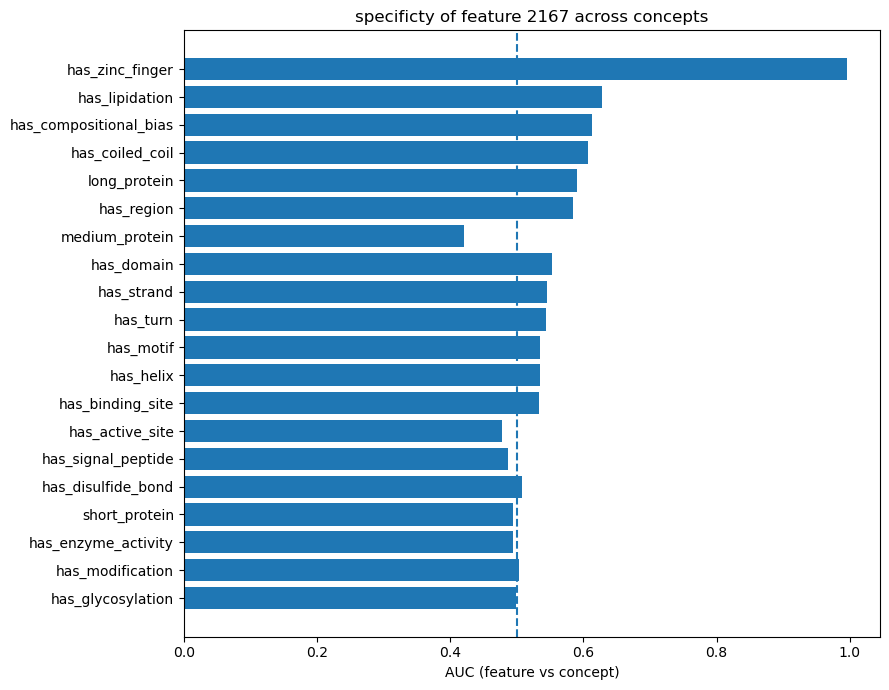

In [ ]:
df_spec = plot_feature_specificty_bar(2167, X, Y, top=None)  # or top=20


In [ ]:
def plot_feature_top_posneg_hist(feature_idx: int,
                                 X_features: np.ndarray,
                                 Y_concepts: pd.DataFrame,
                                 k: int = 3,
                                 bins: int = 30):
    
    """
    For a single feature, find top-k concepts where AUC >> 0.5 (positively associated) and top-k where AUC << 0.5 (negatively associated), 
    and plot the activations of this feature for sequences with these concepts active? wait what.
    """

    df = auc_across_concepts_for_feature(feature_idx, X_features, Y_concepts)
    df = df[np.isfinite(df["auc"])]
    # top k positive(largest AUC) and negative (smallest AUC)
    top_pos = df.sort_values("auc", ascending=False).head(k)
    top_neg = df.sort_values("auc", ascending=True).head(k)

    def _plot_grid(subset, title_prefix):
        for _, row in subset.iterrows():
            concept = row["concept"]
            plot_feature_distributions(feature_idx, concept, X_features, Y_concepts, bins=bins)
    print(f"Top {k} positively associated concepts for feature {feature_idx}:")
    display(top_pos[["concept", "auc", "n_pos", "n_neg"]])
    _plot_grid(top_pos, "Top +")

    print(f"\nTop {k} negatively associated concepts for feature {feature_idx}:")
    display(top_neg[["concept", "auc", "n_pos", "n_neg"]])
    _plot_grid(top_neg, "Top -")


Top 1 positively associated concepts for feature 2167:


,concept,auc,n_pos,n_neg
0,has_zinc_finger,0.995424,831,39169


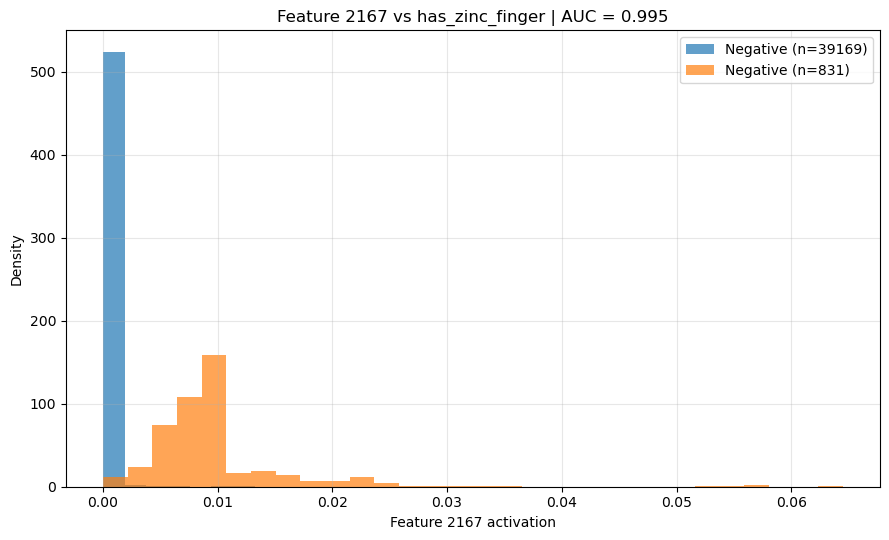


Top 1 negatively associated concepts for feature 2167:


,concept,auc,n_pos,n_neg
6,medium_protein,0.420081,19758,20242


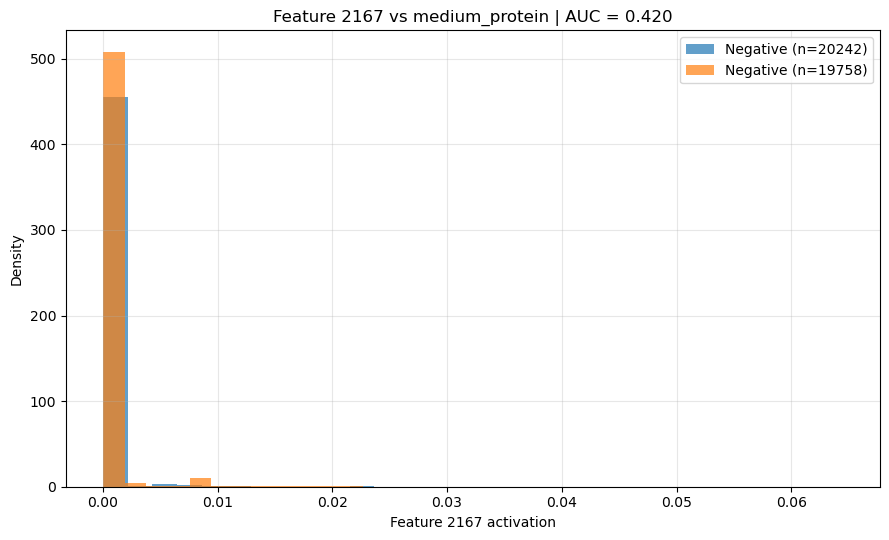

In [ ]:
plot_feature_top_posneg_hist(2167, X, Y, k = 1)

AUC matrix shape (concepts x selected_features):  (20, 151)


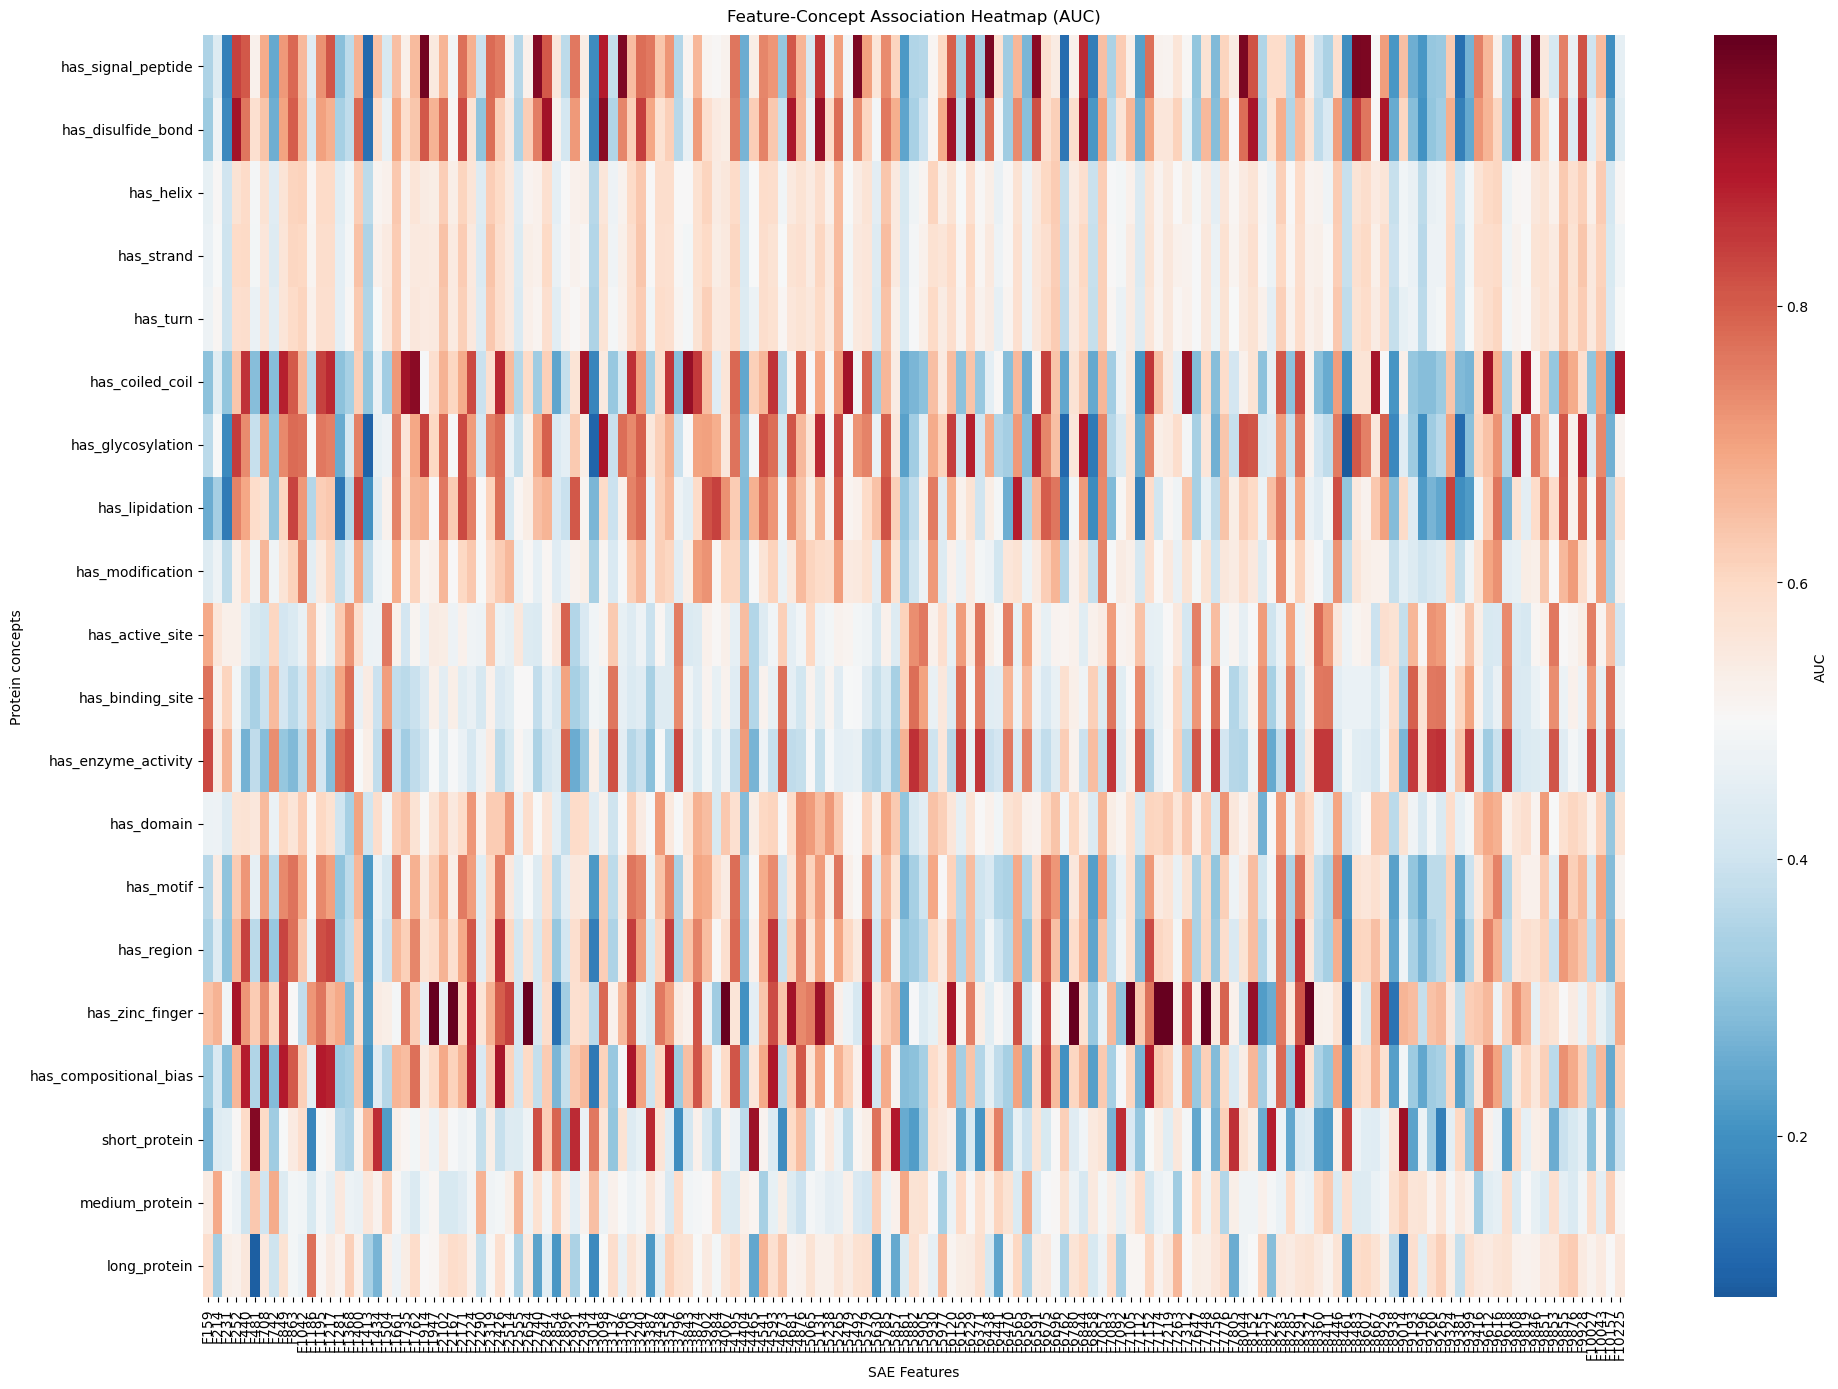


=== Feature Distribution Examples ===
Plotting Feature 481 vs short_protein (AUC=0.954)


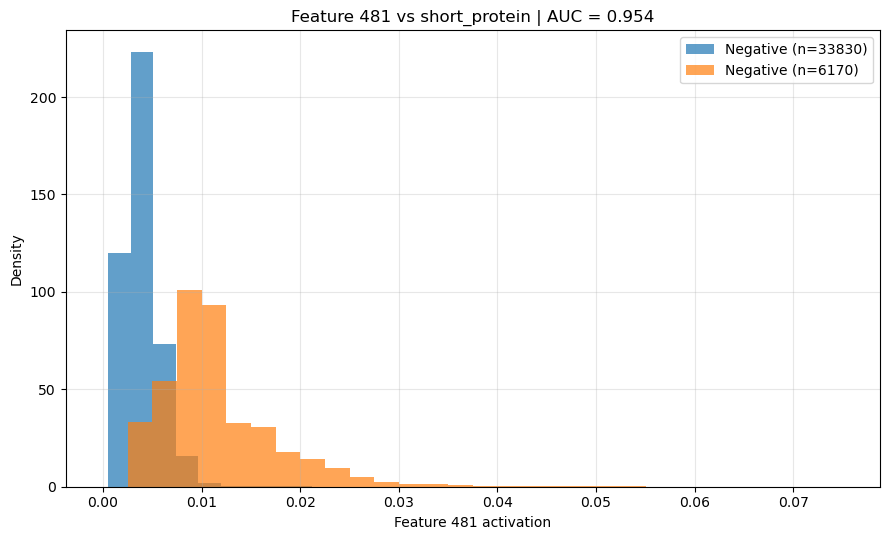

Plotting Feature 3098 vs has_disulfide_bond (AUC=0.948)


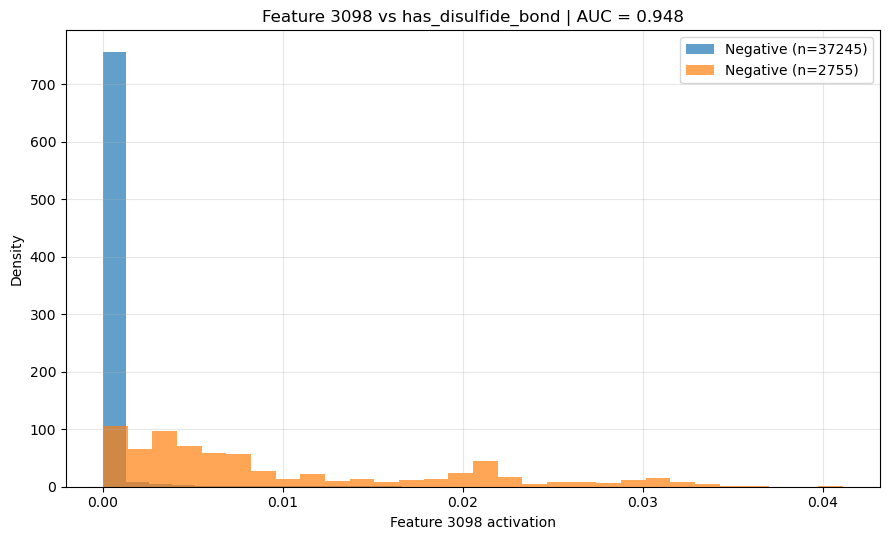

Plotting Feature 1762 vs has_coiled_coil (AUC=0.944)


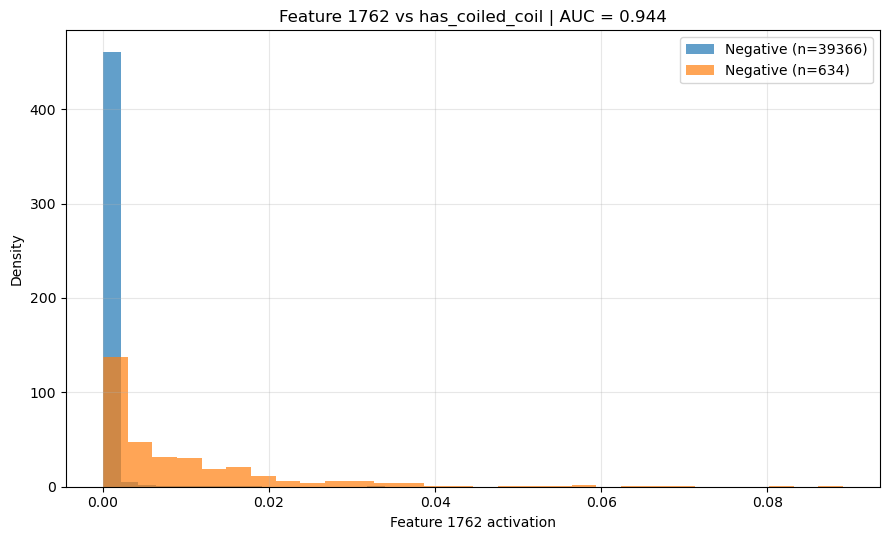

Plotting Feature 6229 vs has_disulfide_bond (AUC=0.940)


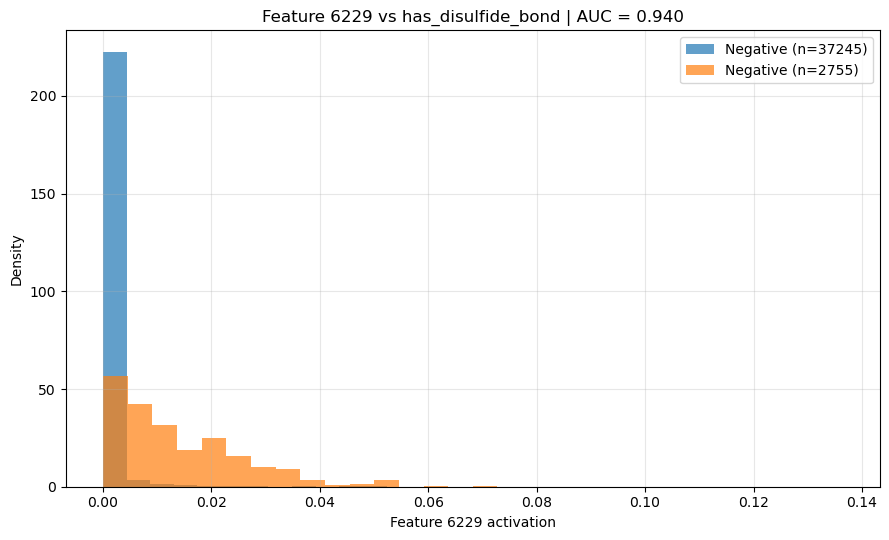

Plotting Feature 3843 vs has_coiled_coil (AUC=0.930)


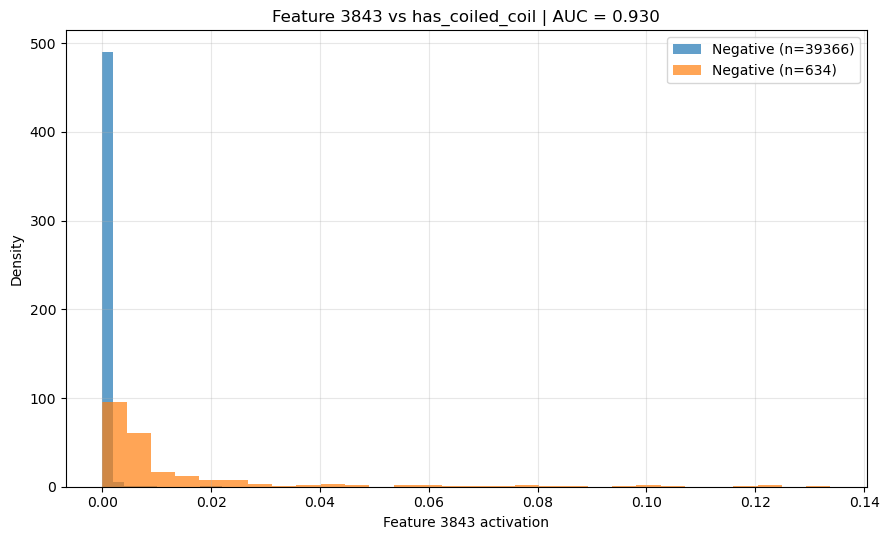

In [ ]:
# Assumes you already have:
# - associations: dict from your AUC analysis
# - X: (N, F) numpy array of features
# - Y: (N, C) DataFrame of 0/1 concepts (same row order as X)

if 'associations' in locals() and len(associations) > 0:
    # Heatmap across the union of top-10 features per concept (cap total if you like)
    auc_matrix, concept_names, top_features = plot_top_features_heatmap(
        associations, X, Y, top_k_per_concept=10, max_features=None
    )

    # Collect strongly discriminative pairs (|AUC - 0.5| > threshold)
    print("\n=== Feature Distribution Examples ===")
    strong = []
    for i, concept in enumerate(concept_names):
        for j, feat_idx in enumerate(top_features):
            auc = auc_matrix[i, j]
            if abs(auc - 0.5) > 0.20:  # threshold; tweak to taste
                strong.append((feat_idx, concept, auc))

    # Sort by how far from random (desc)
    strong.sort(key=lambda t: abs(t[2] - 0.5), reverse=True)
    strong_no_zinc = [t for t in strong if "zinc" not in t[1].lower()]
    strong_no = [t for t in strong_no_zinc if "signal" not in t[1].lower()]

    # strong.filter(key=lambda t: "zinc" in t[1])
    # Plot top 3 pairs
    for feat_idx, concept, auc in strong_no[:5]:
        print(f"Plotting Feature {feat_idx} vs {concept} (AUC={auc:.3f})")
        plot_feature_distributions(feat_idx, concept, X, Y)
else:
    print("Skipping visualizations — 'associations' is missing or empty.")


In [ ]:
strength, fidx, cname, auc_m = strong[0]
debug_auc_pair(cname, fidx, X, Y, concept_names, top_features_cols, auc_matrix)

[short_protein, feat 2854]  matrix AUC = 0.954128   recomputed AUC = 0.787248


(0.9541278683435291, 0.7872481652231028)

## Sequence level analysis

In [ ]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Optional: nicer printing
from textwrap import indent

# Quick sanity on globals you said you already have:
# - aligned_data: DataFrame indexed by UniProt ID, with columns: sequence, protein_name, and concept columns (0/1)
# - Y: DataFrame of concepts aligned to aligned_data (rows = UniProt ID)
# - concept_cols: list of concept column names
# - extract_esm_features: function(seq) -> per-residue hidden states (L, H)
# - extract_sae_features: function(hidden_states) -> (sae_feats, codes, recon); sae_feats shape (L, F)

need = ["aligned_data", "Y", "concept_cols", "extract_esm_features", "extract_sae_features"]
for name in need:
    if name not in globals():
        print(f"WARNING: {name} is not defined in the notebook scope yet.")


In [43]:
#aligned_data analysis
print("aligned_data shape:", aligned_data.shape)
print("aligned_data index name:", aligned_data.index.name)
print("aligned_data columns (first 12):", list(aligned_data.columns)[:12])

req_cols = ["sequence", "protein_name"]
print("num concept columns in aligned_data that match Y:", len([c for c in concept_cols if c in aligned_data.columns]))

example_id = aligned_data.index[0]
row = aligned_data.loc[example_id]
print(f"\nExample ID: {example_id}")
print("protein_name:", row.get("protein_name", "<missing>"))
print("sequence length:", len(row["sequence"]))
print("first 50 aa:", row["sequence"][:50], "...")

aligned_data shape: (40000, 28)
aligned_data index name: None
aligned_data columns (first 12): ['length_feat', 'features', 'max_activation', 'n_active_features', 'reconstruction_mse', 'has_signal_peptide', 'has_disulfide_bond', 'has_helix', 'has_strand', 'has_turn', 'has_coiled_coil', 'has_glycosylation']
num concept columns in aligned_data that match Y: 20

Example ID: Q9GL23
protein_name: Apoptotic protease-activating factor 1 (APAF-1)
sequence length: 50
first 50 aa: ILKKDNYSYISFYNALIHEGYKDLAALLHSGIPVISSSNGGKDSVGGITS ...


In [44]:
def active_concepts_for(protein_row: pd.Series, concept_cols: list[str]) -> list[str]:
    """
    Return concept names where the row has value == 1
    """
    cols = [c for c in concept_cols if c in protein_row.index]
    on = [c for c in cols if int(protein_row[c]) == 1]
    return on

acts = activate_concepts_for(aligned_data.loc[example_id], concept_cols)
print("Active concepts for example", acts[:10], "..." if len(acts) > 10 else "")

NameError: name 'activate_concepts_for' is not defined

In [25]:
# def compute_sae_per_residue(uniprot_id: str):
#     """
#     For a given UniProt ID:
#     1) Fetch sequence from aligned_data
#     2) run ESM to get hidden states: (L, H) len sequence to 1280? => 10240
#     3) run SAE projection to get features: (L, F) len sesquence to expanding the features?
    
#     Returns:
#     sequence(str), sae_features (torch.Tensor, shape L x F)
#     """
#     hidden_states = extract_esm_features(seq)
    
def analyze_sequence_features_batched(uid: str, top_k_features: int=5):
    """
    Plotting activations per feature? hmmm
    """
    seq = aligned_data.loc[uid, "sequence"]
    print(f"\n=== Analysis for {uid} ===")
    print("Protein name:", aligned_data.loc[uid].get("protein_name", "<missing>"))
    print("Length:", len(seq), "residues")

    #show activate concepts
    acts = [c for c in concept_cols if c in aligned_data.columns and int(aligned_data.loc[uid, c]) == 1]
    print("Active concepts:", ", ".join(acts) if acts else "None")

    #Run B=1 through esm for hidden states
    hs, mask = extract_esm_features_batch([seq], layer_sel=24, model=model, tokenizer=tokenizer) #(B, L, H)
    sae_feat, recon, err = extract_sae_features(hs, sae) #[1, LPad, F]

    L_valid = int(mask[0].sum().item())
    sae_1 = sae_feat[0, :L_valid, :] #[L = #residues for rows, F features for columns]

    mean_acts = sae_1.mean(dim=0) #F, mean across the rows
    k = min(top_k_features, mean_acts.numel())
    top_idx = torch.topk(mean_acts, k).indices

    print(f"\nTop {k} features by mean activation:")
    for rank, f_idx in enumerate(top_idx.tolist(), start=1):
        arr = sae_1[:, f_idx].detach().cpu().numpy()
        print(f"  {rank:>2}. Feature {f_idx:4d} | mean={arr.mean():.3f} | max={arr.max():.3f}")
    
    #plotting traces
    x = np.arange(L_valid)
    fig, axes = plt.subplots(k, 1, figsize=(12, 2.2 * k), sharex=True)  # ✅ fixed parens
    if k == 1:
        axes = [axes]

    for i, f_idx in enumerate(top_idx.tolist()):
        activ = sae_1[:, f_idx].detach().cpu().numpy()
        axes[i].plot(x, activ, linewidth=2)
        axes[i].set_ylabel(f"F{f_idx}")
        axes[i].set_title(f"Feature {f_idx} (mean={mean_acts[f_idx].item():.3f})")
        axes[i].grid(True, alpha=0.3)

        # Highlight high activation regions (> mean + 2 std)
        thr = activ.mean() + 2 * activ.std()
        high = activ > thr
        if high.any():  # ✅ added colon
            axes[i].fill_between(x, 0, activ, where=high, alpha=0.25)

    axes[-1].set_xlabel("Residue position")
    plt.suptitle(f"SAE per-residue activations - {uid}", y=1.02)
    plt.tight_layout()
    plt.show()

    return sae_1, top_idx





    

In [24]:
examples = []

# 1) Protein with signal peptide (if column exists)
if "has_turn" in Y.columns:
    ids = Y.index[Y["has_turn"] == 1]
    if len(ids) > 0:
        examples.append(ids[0])

# 2) Protein with enzyme activity
if "has_zinc_finger" in Y.columns:
    ids = Y.index[Y["has_zinc_finger"] == 1]
    if len(ids) > 0:
        examples.append(ids[0])

# 3) Protein with domains
if "has_motif" in Y.columns:
    ids = Y.index[Y["has_motif"] == 1]
    if len(ids) > 0:
        examples.append(ids[0])

# 4) Protein with helix
if "has_helix" in Y.columns:
    ids = Y.index[Y["has_helix"] == 1]
    if len(ids) > 0:
        examples.append(ids[0])

# Remove duplicates, keep order, and cap at 3 (or increase cap if you want 4)
examples = list(dict.fromkeys(examples))[:4]

print("Examples picked:", examples)


Examples picked: ['Q3ZBI7', 'Q9NYG5', 'Q29005']



=== Analysis for Q3ZBI7 ===
Protein name: ATP synthase F(0) complex subunit k, mitochondrial (ATP synthase membrane subunit DAPIT, mitochondrial) (Diabetes-associated protein in insulin-sensitive tissues) (Up-regulated during skeletal muscle growth protein 5)
Length: 58 residues
Active concepts: has_helix, has_strand, has_turn, has_modification, short_protein

Top 10 features by mean activation:
   1. Feature 8496 | mean=0.318 | max=0.565
   2. Feature 2219 | mean=0.188 | max=0.395
   3. Feature 7035 | mean=0.183 | max=0.555
   4. Feature 8018 | mean=0.175 | max=0.309
   5. Feature 10081 | mean=0.140 | max=0.532
   6. Feature 7810 | mean=0.119 | max=0.286
   7. Feature 8194 | mean=0.112 | max=0.358
   8. Feature  857 | mean=0.102 | max=0.328
   9. Feature 7806 | mean=0.097 | max=0.585
  10. Feature  810 | mean=0.096 | max=0.580


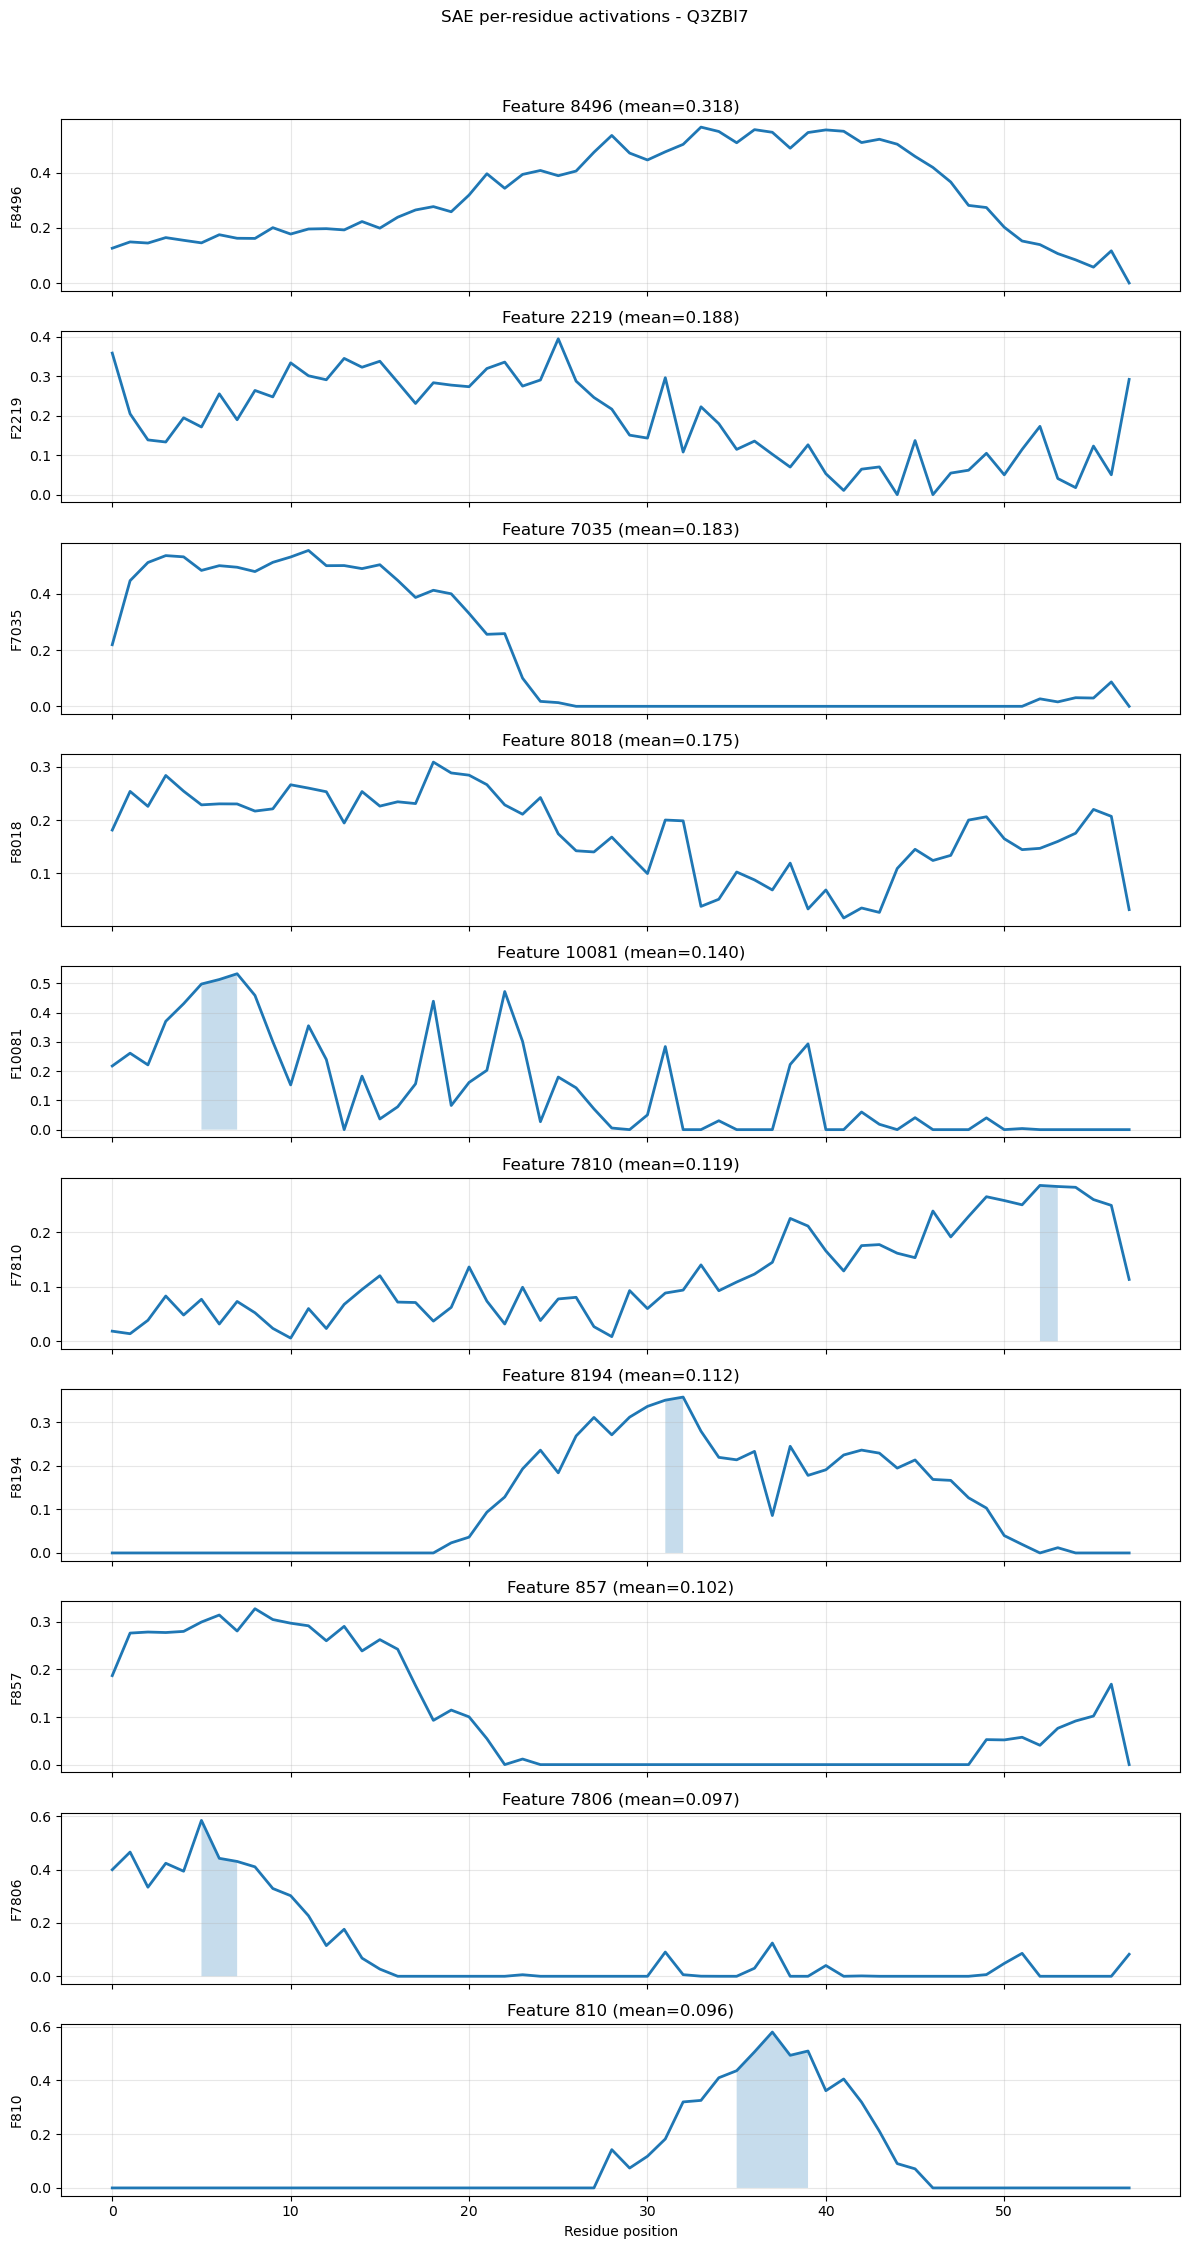


=== Analysis for Q9NYG5 ===
Protein name: Anaphase-promoting complex subunit 11 (APC11) (Cyclosome subunit 11) (Hepatocellular carcinoma-associated RING finger protein)
Length: 84 residues
Active concepts: has_helix, has_strand, has_turn, has_binding_site, has_zinc_finger, short_protein

Top 10 features by mean activation:
   1. Feature 1301 | mean=0.178 | max=0.781
   2. Feature 10156 | mean=0.167 | max=0.945
   3. Feature 6315 | mean=0.158 | max=0.779
   4. Feature 7386 | mean=0.113 | max=0.813
   5. Feature 5674 | mean=0.109 | max=0.717
   6. Feature 1505 | mean=0.076 | max=0.252
   7. Feature 9765 | mean=0.069 | max=0.427
   8. Feature 7102 | mean=0.067 | max=0.398
   9. Feature 8710 | mean=0.066 | max=0.770
  10. Feature 2347 | mean=0.063 | max=0.612


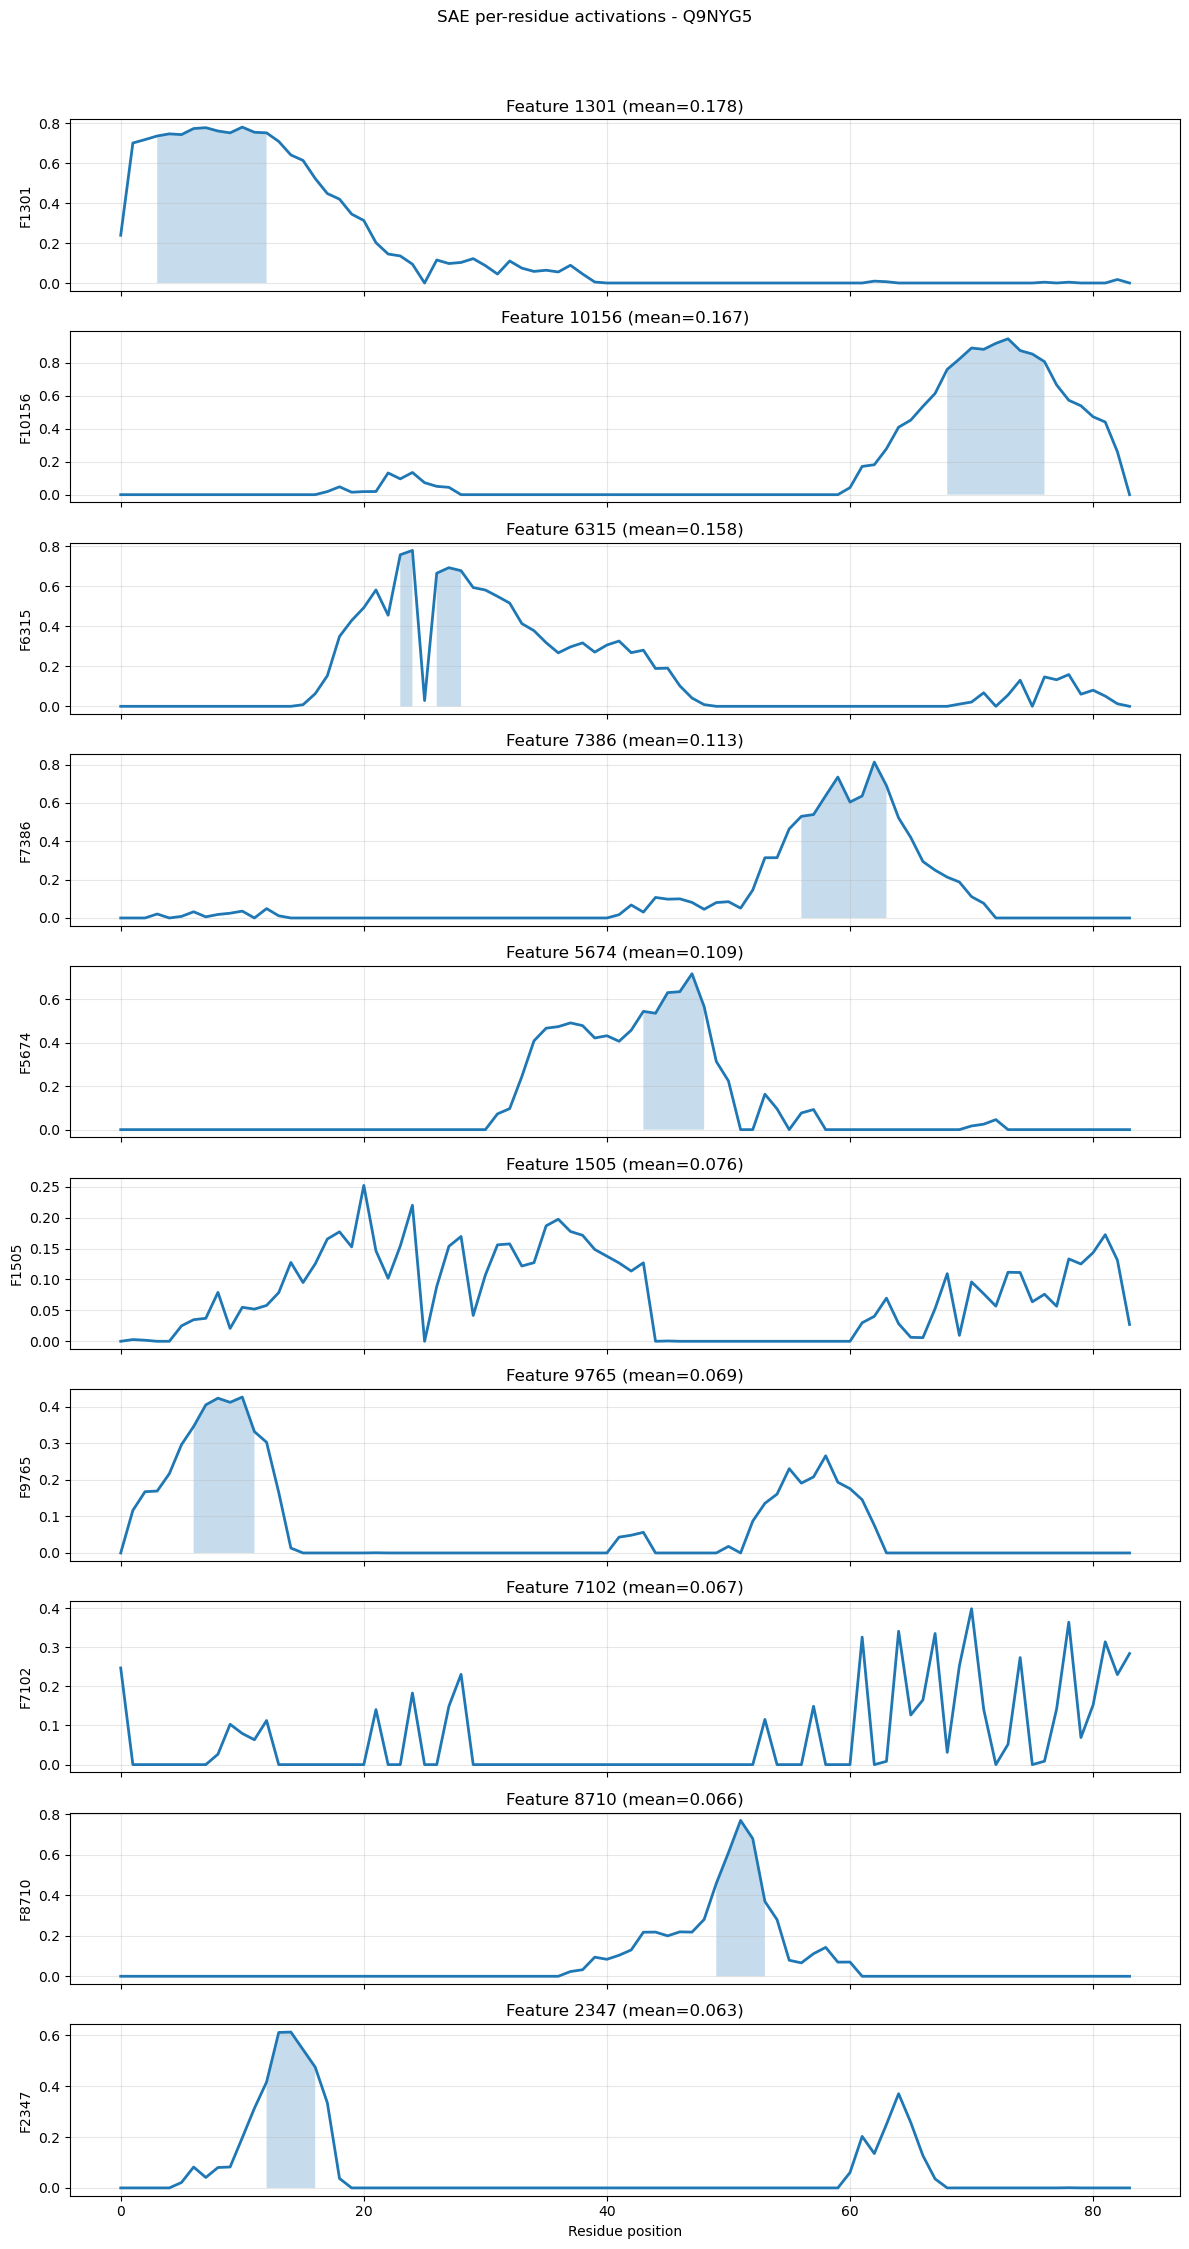


=== Analysis for Q29005 ===
Protein name: 5-hydroxytryptamine receptor 2B (5-HT-2B) (5-HT2B) (Serotonin receptor 2B)
Length: 60 residues
Active concepts: has_binding_site, has_motif, short_protein

Top 10 features by mean activation:
   1. Feature 1196 | mean=0.190 | max=0.796
   2. Feature 8804 | mean=0.184 | max=0.818
   3. Feature 7127 | mean=0.161 | max=0.854
   4. Feature 2349 | mean=0.147 | max=0.752
   5. Feature 1068 | mean=0.141 | max=0.435
   6. Feature 6945 | mean=0.134 | max=0.423
   7. Feature 9551 | mean=0.101 | max=0.345
   8. Feature 1922 | mean=0.096 | max=0.930
   9. Feature 4187 | mean=0.083 | max=0.802
  10. Feature 7487 | mean=0.082 | max=0.694


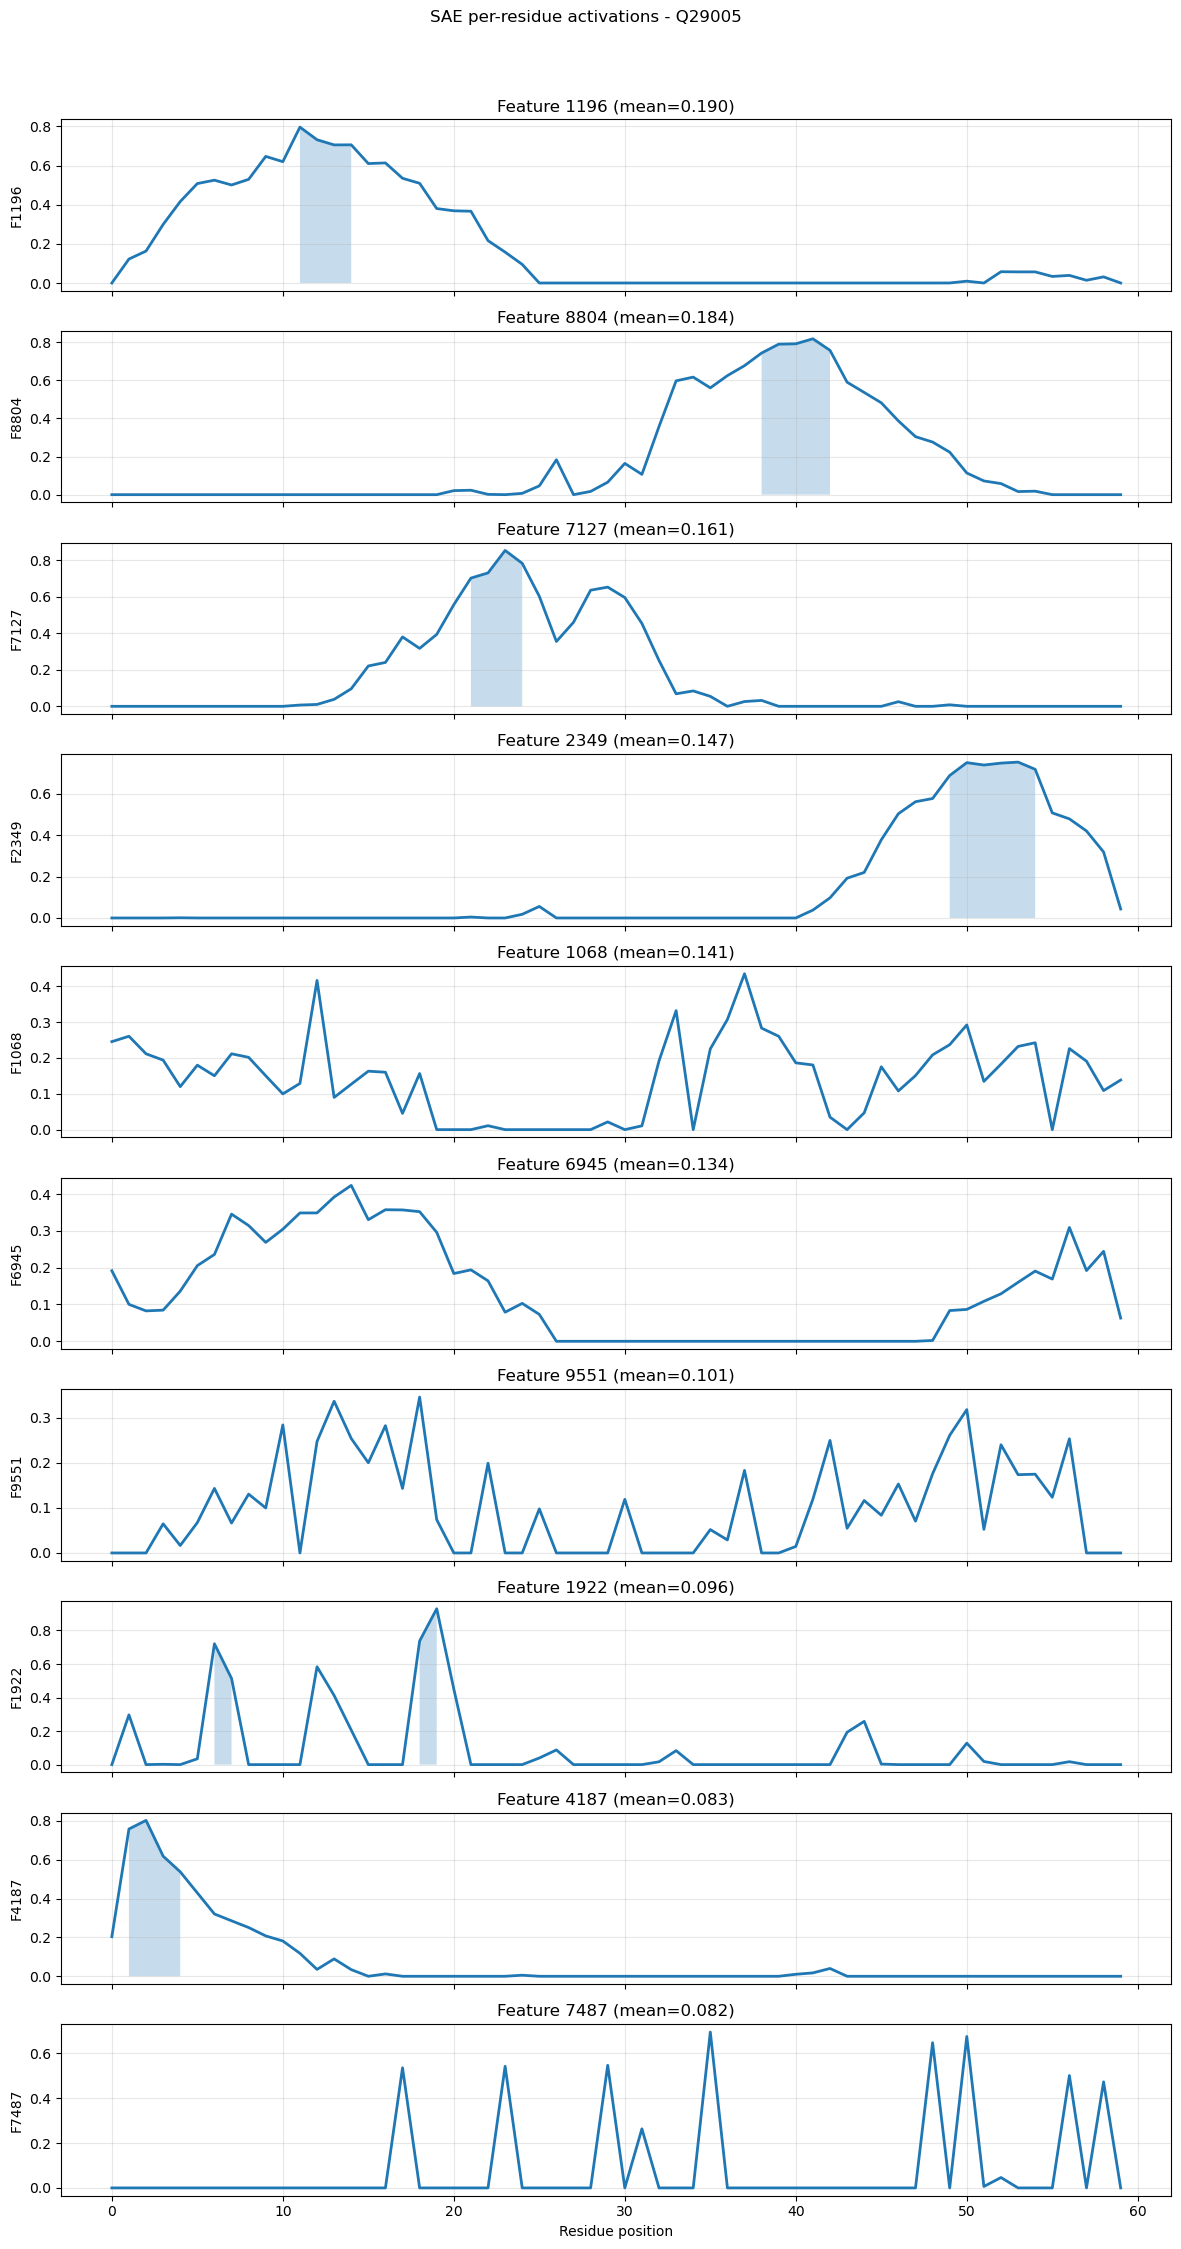

In [26]:
for uid in examples:
    _sae, _top = analyze_sequence_features_batched(uid, top_k_features=10)
    



=== Analysis for Q3ZBI7 ===
Protein name: ATP synthase F(0) complex subunit k, mitochondrial (ATP synthase membrane subunit DAPIT, mitochondrial) (Diabetes-associated protein in insulin-sensitive tissues) (Up-regulated during skeletal muscle growth protein 5)
Length: 58 residues
Active concepts: has_helix, has_strand, has_turn, has_modification, short_protein

Feature 2167: mean=0.000, max=0.000


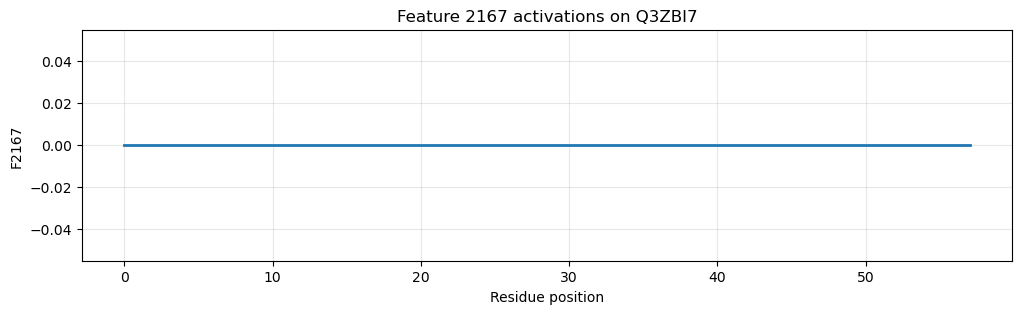


=== Analysis for Q9NYG5 ===
Protein name: Anaphase-promoting complex subunit 11 (APC11) (Cyclosome subunit 11) (Hepatocellular carcinoma-associated RING finger protein)
Length: 84 residues
Active concepts: has_helix, has_strand, has_turn, has_binding_site, has_zinc_finger, short_protein

Feature 2167: mean=0.057, max=0.637


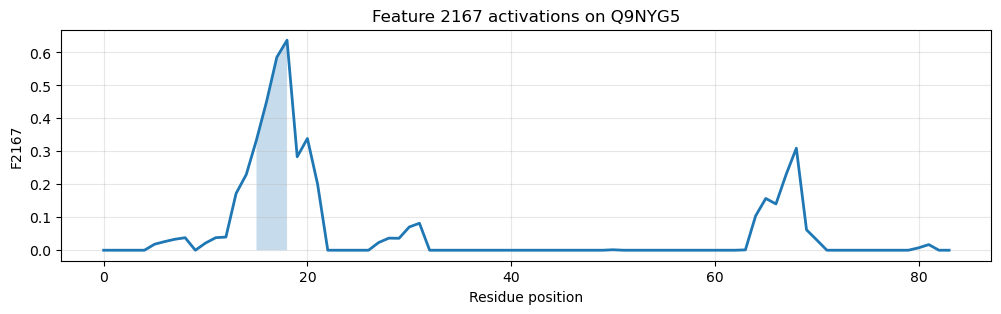


=== Analysis for Q29005 ===
Protein name: 5-hydroxytryptamine receptor 2B (5-HT-2B) (5-HT2B) (Serotonin receptor 2B)
Length: 60 residues
Active concepts: has_binding_site, has_motif, short_protein

Feature 2167: mean=0.000, max=0.000


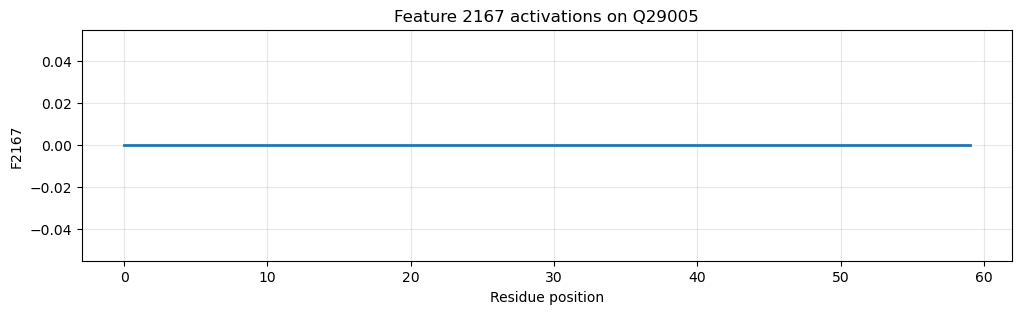

In [27]:
def visualize_feature_on_sequence(uid: str, feature_id: int):
    """
    For a given UniProt ID and SAE feature:
    - Extract per-residue SAE activations
    - Plot the activation trace along the sequence
    """

    seq = aligned_data.loc[uid, "sequence"]
    print(f"\n=== Analysis for {uid} ===")
    print("Protein name:", aligned_data.loc[uid].get("protein_name", "<missing>"))
    print("Length:", len(seq), "residues")

    # Which concepts are active for this protein
    acts = [c for c in concept_cols if c in aligned_data.columns and int(aligned_data.loc[uid, c]) == 1]
    print("Active concepts:", ", ".join(acts) if acts else "None")

    # Run ESM → SAE
    hs, mask = extract_esm_features_batch([seq], layer_sel=24, model=model, tokenizer=tokenizer)  # (B, L, H)
    sae_feat, recon, err = extract_sae_features(hs, sae)  # (B, L_pad, F)

    # Clip padding
    L_valid = int(mask[0].sum().item())
    sae_1 = sae_feat[0, :L_valid, :]  # (L, F)

    # Extract activations for the chosen feature
    activ = sae_1[:, feature_id].detach().cpu().numpy()
    mean_val, max_val = activ.mean(), activ.max()

    print(f"\nFeature {feature_id}: mean={mean_val:.3f}, max={max_val:.3f}")

    # Plot per-residue activations
    x = np.arange(L_valid)
    plt.figure(figsize=(12, 3))
    plt.plot(x, activ, linewidth=2)
    plt.ylabel(f"F{feature_id}")
    plt.xlabel("Residue position")
    plt.title(f"Feature {feature_id} activations on {uid}")
    plt.grid(True, alpha=0.3)

    # Highlight strong activations (> mean + 2*std)
    thr = activ.mean() + 2 * activ.std()
    high = activ > thr
    if high.any():
        plt.fill_between(x, 0, activ, where=high, alpha=0.25)

    plt.show()

    return seq, activ

for uid in examples:
    seq, activ = visualize_feature_on_sequence(uid, 2167)


In [29]:
from termcolor import colored  # pip install termcolor

def visualize_feature_on_sequence(uid: str, feature_id: int, zscore_threshold: float = 2.0):
    """
    For a given UniProt ID and SAE feature:
    - Extract per-residue SAE activations
    - Plot the activation trace along the sequence
    - Print the sequence, highlighting high-activation residues in red
    """

    seq = aligned_data.loc[uid, "sequence"]
    print(f"\n=== Analysis for {uid} ===")
    print("Protein name:", aligned_data.loc[uid].get("protein_name", "<missing>"))
    print("Length:", len(seq), "residues")

    # Which concepts are active for this protein
    acts = [c for c in concept_cols if c in aligned_data.columns and int(aligned_data.loc[uid, c]) == 1]
    print("Active concepts:", ", ".join(acts) if acts else "None")

    # Run ESM → SAE
    hs, mask = extract_esm_features_batch([seq], layer_sel=24, model=model, tokenizer=tokenizer)  # (B, L, H)
    sae_feat, recon, err = extract_sae_features(hs, sae)  # (B, L_pad, F)

    # Clip padding
    L_valid = int(mask[0].sum().item())
    sae_1 = sae_feat[0, :L_valid, :]  # (L, F)

    # Extract activations for the chosen feature
    activ = sae_1[:, feature_id].detach().cpu().numpy()
    mean_val, std_val = activ.mean(), activ.std()
    max_val = activ.max()

    print(f"\nFeature {feature_id}: mean={mean_val:.3f}, max={max_val:.3f}")

    # Threshold for "strong activation"
    thr = mean_val + zscore_threshold * std_val
    high_mask = activ > thr

    # Plot per-residue activations
    x = np.arange(L_valid)
    plt.figure(figsize=(12, 3))
    plt.plot(x, activ, linewidth=2)
    plt.ylabel(f"F{feature_id}")
    plt.xlabel("Residue position")
    plt.title(f"Feature {feature_id} activations on {uid}")
    plt.grid(True, alpha=0.3)

    # Highlight strong activations
    if high_mask.any():
        plt.fill_between(x, 0, activ, where=high_mask, alpha=0.25)

    plt.show()

    # Print sequence with high activations in red
    print("\nSequence with high activations:")
    highlighted = "".join(
        colored(aa, "red") if high else aa
        for aa, high in zip(seq, high_mask)
    )
    print(highlighted)

    return seq, activ, high_mask



=== Analysis for Q3ZBI7 ===
Protein name: ATP synthase F(0) complex subunit k, mitochondrial (ATP synthase membrane subunit DAPIT, mitochondrial) (Diabetes-associated protein in insulin-sensitive tissues) (Up-regulated during skeletal muscle growth protein 5)
Length: 58 residues
Active concepts: has_helix, has_strand, has_turn, has_modification, short_protein

Feature 2167: mean=0.000, max=0.000


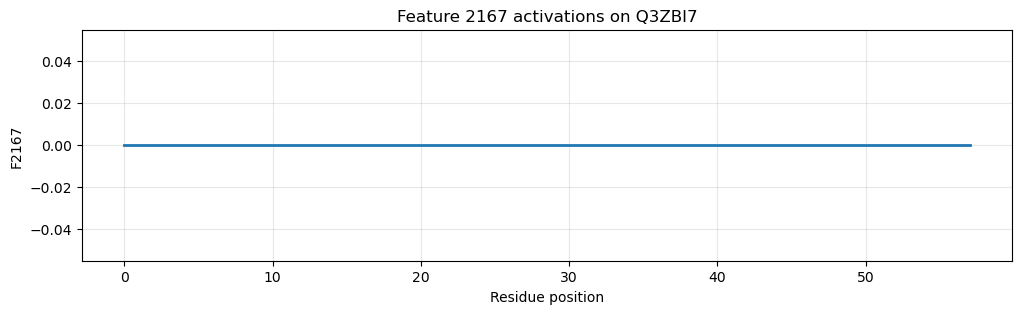


Sequence with high activations:
MAGPEADAQFHFTGIKKYFNSYTLTGRMNCVLATYGSIALIVLYFKLRSKKTPAVKAT

=== Analysis for Q9NYG5 ===
Protein name: Anaphase-promoting complex subunit 11 (APC11) (Cyclosome subunit 11) (Hepatocellular carcinoma-associated RING finger protein)
Length: 84 residues
Active concepts: has_helix, has_strand, has_turn, has_binding_site, has_zinc_finger, short_protein

Feature 2167: mean=0.057, max=0.637


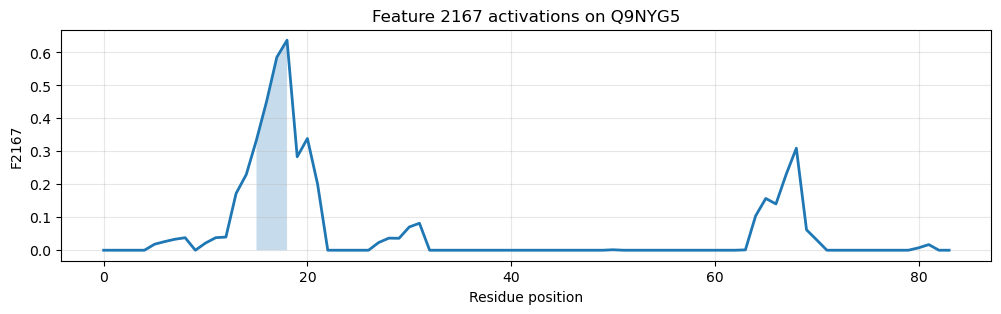


Sequence with high activations:
MKVKIKCWNGVATWLWVANDENCGICRMAFNGCCPDCKVPGDDCPLVWGQCSHCFHMHCILKWLHAQQVQQHCPMCRQEWKFKE

=== Analysis for Q29005 ===
Protein name: 5-hydroxytryptamine receptor 2B (5-HT-2B) (5-HT2B) (Serotonin receptor 2B)
Length: 60 residues
Active concepts: has_binding_site, has_motif, short_protein

Feature 2167: mean=0.000, max=0.000


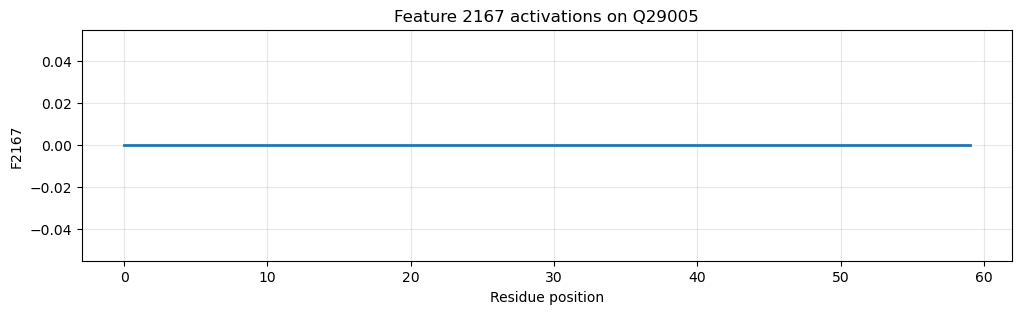


Sequence with high activations:
VLCPAWLFLDVLFSTASIMHLCAISVDRYIAIKKPIQANQYNSRATAFIKITVVWLISIG


In [30]:
# uid = "Q9NYG5"        # UniProt ID with zinc finger
feature_id = 2167     # zinc finger SAE feature
for uid in examples:
    seq, activ, high_mask = visualize_feature_on_sequence(uid, feature_id)


## 11. Feature Interpretation and Biological Insights

Summarize findings and provide biological interpretation of discovered features.

In [ ]:

from collections import defaultdict

def summarize_feature_analysis(associations: dict, min_auc_deviation: float = 0.2):
    """
    Summarize the key findings from feature-concept associations.
    """
    print("=== SAE Feature Analysis Summary ===")
    print(f"\nAnalyzed {len(associations)} protein concepts")
    
    # Count strong associations
    strong_associations = []
    all_features = set()
    
    for concept, data in associations.items():
        for feature_idx, auc in data['top_features']:
            if abs(auc - 0.5) > min_auc_deviation:
                strong_associations.append((concept, feature_idx, auc))
                all_features.add(feature_idx)
    
    print(f"Found {len(strong_associations)} strong feature-concept associations")
    print(f"Involving {len(all_features)} distinct SAE features")
    
    # Group by concept type
    structural_concepts = []
    functional_concepts = []
    modification_concepts = []
    
    for concept, feature_idx, auc in strong_associations:
        if any(keyword in concept.lower() for keyword in ['helix', 'strand', 'coil', 'domain', 'structure']):
            structural_concepts.append((concept, feature_idx, auc))
        elif any(keyword in concept.lower() for keyword in ['enzyme', 'binding', 'active', 'function']):
            functional_concepts.append((concept, feature_idx, auc))
        elif any(keyword in concept.lower() for keyword in ['glyco', 'lipid', 'modification', 'signal']):
            modification_concepts.append((concept, feature_idx, auc))
    
    print(f"\n=== Associations by Category ===")
    print(f"Structural features: {len(structural_concepts)}")
    print(f"Functional features: {len(functional_concepts)}")
    print(f"Modification features: {len(modification_concepts)}")
    
    # Display top associations in each category
    categories = [
        ("Structural", structural_concepts),
        ("Functional", functional_concepts),
        ("Modification", modification_concepts)
    ]
    
    for category_name, concepts in categories:
        if concepts:
            print(f"\n--- {category_name} Features ---")
            # Sort by AUC deviation from 0.5
            concepts.sort(key=lambda x: abs(x[2] - 0.5), reverse=True)
            for i, (concept, feature_idx, auc) in enumerate(concepts[:5]):
                direction = "activates for" if auc > 0.5 else "suppresses for"
                print(f"  {i+1}. Feature {feature_idx:4d} {direction} {concept} (AUC={auc:.3f})")
    
    return strong_associations, all_features

def create_feature_summary_table(associations: dict, aligned_data: pd.DataFrame):
    """
    Create a summary table of the most important features.
    """
    # Collect all feature scores
    feature_scores = defaultdict(list)
    
    for concept, data in associations.items():
        for feature_idx, auc in data['top_features'][:10]:
            feature_scores[feature_idx].append({
                'concept': concept,
                'auc': auc,
                'deviation': abs(auc - 0.5)
            })
    
    # Summarize each feature
    feature_summary = []
    
    for feature_idx, scores in feature_scores.items():
        scores.sort(key=lambda x: x['deviation'], reverse=True)
        
        # Get top associated concepts
        top_concepts = scores[:3]
        max_deviation = max(score['deviation'] for score in scores)
        
        # Count how often this feature is active
        feature_activations = X[:, feature_idx]
        n_active = (feature_activations > 0.0).sum()
        mean_activation = feature_activations.mean()
        
        feature_summary.append({
            'feature_idx': feature_idx,
            'max_auc_deviation': max_deviation,
            'n_strong_concepts': len([s for s in scores if s['deviation'] > 0.2]),
            'top_concept': top_concepts[0]['concept'] if top_concepts else 'None',
            'top_auc': top_concepts[0]['auc'] if top_concepts else 0.5,
            'n_active_proteins': n_active,
            'activation_rate': n_active / len(feature_activations),
            'mean_activation': mean_activation
        })
    
    # Convert to DataFrame and sort
    summary_df = pd.DataFrame(feature_summary)
    summary_df = summary_df.sort_values('max_auc_deviation', ascending=False)
    
    return summary_df

# Generate summary
strong_associations, important_features = summarize_feature_analysis(associations)

# Create detailed feature table
feature_summary_df = create_feature_summary_table(associations, aligned_data)

print(f"\n=== Top 10 Most Interpretable SAE Features ===")
display_cols = ['feature_idx', 'max_auc_deviation', 'n_strong_concepts', 'top_concept', 'top_auc', 
                'activation_rate', 'mean_activation']
print(feature_summary_df[display_cols].head(10).to_string(index=False, float_format='%.6f'))

# Save results
results_dir = DATA_DIR / 'analysis_results'
results_dir.mkdir(exist_ok=True)

feature_summary_df.to_csv(results_dir / 'sae_feature_summary.csv', index=False)
pd.DataFrame(strong_associations, columns=['concept', 'feature_idx', 'auc']).to_csv(
    results_dir / 'strong_associations.csv', index=False)

print(f"\nResults saved to {results_dir}/")
print(f"- sae_feature_summary.csv: Summary of all features")
print(f"- strong_associations.csv: All strong feature-concept associations")

=== SAE Feature Analysis Summary ===

Analyzed 20 protein concepts
Found 313 strong feature-concept associations
Involving 235 distinct SAE features

=== Associations by Category ===
Structural features: 40
Functional features: 60
Modification features: 73

--- Structural Features ---
  1. Feature 1762 activates for has_coiled_coil (AUC=0.944)
  2. Feature 3843 activates for has_coiled_coil (AUC=0.930)
  3. Feature 7312 activates for has_coiled_coil (AUC=0.921)
  4. Feature 5479 activates for has_coiled_coil (AUC=0.917)
  5. Feature 1735 activates for has_coiled_coil (AUC=0.915)

--- Functional Features ---
  1. Feature 5882 activates for has_enzyme_activity (AUC=0.861)
  2. Feature 9265 activates for has_enzyme_activity (AUC=0.860)
  3. Feature 7083 activates for has_enzyme_activity (AUC=0.851)
  4. Feature 9260 activates for has_enzyme_activity (AUC=0.850)
  5. Feature 6371 activates for has_enzyme_activity (AUC=0.850)

--- Modification Features ---
  1. Feature 1914 activates for ha

In [123]:
feature_summary_df['mean_activation'].describe()
feature_summary_df['mean_activation'].head(10).apply(lambda x: f"{x:.6e}")


114    1.946573e-04
115    1.887219e-04
116    3.342144e-04
117    1.897878e-04
118    4.324070e-04
119    4.888494e-05
120    1.842735e-04
121    2.502378e-04
122    2.245264e-04
123    1.615664e-04
Name: mean_activation, dtype: object

In [124]:
f_idx = 8327
vals = X[:, f_idx]
print("mean:", vals.mean())
print("nonzeros:", (vals > 0).sum(), " / ", len(vals))
print("max:", vals.max())
print("percentile 99.9:", np.percentile(vals, 99.9))


mean: 0.00019465727
nonzeros: 8834  /  40000
max: 0.031864047
percentile 99.9: 0.012961490683258312
